In [71]:
import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [72]:
qual_cols = { "age", "TSH", "T3", "TT4", "T4U", "FTI", "TBG" }
cat_cols = { "sex", "on_thyroxine", "on_antithyroid_meds", "sick", "pregnant", "thyroid_surgery", "I131_treatment", "lithium", "goitre", "tumor", "psych", "referral_source", "target" }

In [73]:
remove_qual_cols = { "TBG" }
remove_cat_cols = set()

In [74]:
k = 10
neighbours = 10
iters = 10

In [75]:
seed = 42

In [76]:
random_state = np.random.RandomState(seed)
random_generator = np.random.default_rng(seed)

In [77]:
sel_qual_cols = list(qual_cols.difference(remove_qual_cols))
sel_cat_cols = list(cat_cols.difference(remove_cat_cols))
display(sel_qual_cols)
display(sel_cat_cols)

['TSH', 'FTI', 'age', 'TT4', 'T3', 'T4U']

['on_thyroxine',
 'sex',
 'I131_treatment',
 'target',
 'sick',
 'on_antithyroid_meds',
 'goitre',
 'referral_source',
 'pregnant',
 'lithium',
 'thyroid_surgery',
 'psych',
 'tumor']

In [78]:
df = pd.read_csv("./data/thyroidDF.csv")
df

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,...,NaN,f,NaN,f,NaN,f,NaN,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,...,128.0,f,NaN,f,NaN,f,NaN,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,11.0,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,26.0,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,36.0,other,S,840803047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9167,56,M,f,f,f,f,f,f,f,f,...,64.0,t,0.83,t,77.0,f,NaN,SVI,-,870119022
9168,22,M,f,f,f,f,f,f,f,f,...,91.0,t,0.92,t,99.0,f,NaN,SVI,-,870119023
9169,69,M,f,f,f,f,f,f,f,f,...,113.0,t,1.27,t,89.0,f,NaN,SVI,I,870119025
9170,47,F,f,f,f,f,f,f,f,f,...,75.0,t,0.85,t,88.0,f,NaN,other,-,870119027


In [79]:
df.dropna()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
167,40,F,f,f,f,f,f,f,f,f,...,3.9,t,0.83,t,5.0,t,28.0,other,F,840827019
5256,35,F,f,f,f,f,f,t,f,f,...,73.0,t,1.16,t,63.0,t,37.0,other,-,851128040
6044,77,F,f,f,f,f,f,f,f,f,...,120.0,t,0.96,t,124.0,t,45.0,SVI,-,860305064
6045,73,M,f,f,f,f,f,f,f,f,...,89.0,t,0.74,t,119.0,t,24.0,SVI,-,860305065
6747,77,F,f,f,f,f,f,f,f,f,...,131.0,t,1.04,t,126.0,t,25.0,SVI,K,860702030
6773,74,F,f,f,f,f,f,f,f,f,...,116.0,t,0.81,t,143.0,t,22.0,SVI,-,860703046
6862,60,M,f,f,f,f,f,f,f,f,...,92.0,t,0.84,t,110.0,t,21.0,other,-,860710043
6863,66,F,f,f,f,f,f,f,f,f,...,138.0,t,0.80,t,173.0,t,15.0,SVI,-,860710044
6880,42,F,f,f,f,f,f,f,f,f,...,106.0,t,0.98,t,108.0,t,27.0,other,-,860711039
6934,29,F,f,f,f,f,f,f,f,f,...,122.0,t,1.14,t,107.0,t,36.0,SVI,-,860717007


In [80]:
df[sel_qual_cols]

,TSH,FTI,age,TT4,T3,T4U
0,0.3,NaN,29,NaN,NaN,NaN
1,1.6,NaN,29,128.0,1.9,NaN
2,NaN,NaN,41,NaN,NaN,NaN
3,NaN,NaN,36,NaN,NaN,NaN
4,NaN,NaN,32,NaN,NaN,NaN
...,...,...,...,...,...,...
9167,NaN,77.0,56,64.0,NaN,0.83
9168,NaN,99.0,22,91.0,NaN,0.92
9169,NaN,89.0,69,113.0,NaN,1.27
9170,NaN,88.0,47,75.0,NaN,0.85


In [81]:
df[sel_cat_cols]

,on_thyroxine,sex,I131_treatment,target,sick,on_antithyroid_meds,goitre,referral_source,pregnant,lithium,thyroid_surgery,psych,tumor
0,f,F,f,-,f,f,f,other,f,f,f,f,f
1,f,F,f,-,f,f,f,other,f,f,f,f,f
2,f,F,f,-,f,f,f,other,f,f,f,f,f
3,f,F,f,-,f,f,f,other,f,f,f,f,f
4,f,F,f,S,f,f,f,other,f,f,f,f,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9167,f,M,f,-,f,f,f,SVI,f,f,f,f,f
9168,f,M,f,-,f,f,f,SVI,f,f,f,f,f
9169,f,M,f,I,f,f,f,SVI,f,f,f,f,f
9170,f,F,f,-,f,f,f,other,f,f,f,f,f


In [82]:
df = df[(df["age"] >= 0) & (df["age"] < 100)]
df

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,...,NaN,f,NaN,f,NaN,f,NaN,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,...,128.0,f,NaN,f,NaN,f,NaN,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,11.0,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,26.0,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,36.0,other,S,840803047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9167,56,M,f,f,f,f,f,f,f,f,...,64.0,t,0.83,t,77.0,f,NaN,SVI,-,870119022
9168,22,M,f,f,f,f,f,f,f,f,...,91.0,t,0.92,t,99.0,f,NaN,SVI,-,870119023
9169,69,M,f,f,f,f,f,f,f,f,...,113.0,t,1.27,t,89.0,f,NaN,SVI,I,870119025
9170,47,F,f,f,f,f,f,f,f,f,...,75.0,t,0.85,t,88.0,f,NaN,other,-,870119027


In [83]:
qual_na_df = df[sel_qual_cols].dropna()
qual_na_df

,TSH,FTI,age,TT4,T3,T4U
19,1.50,85.0,36,90.0,2.4,1.06
21,1.20,96.0,40,104.0,2.3,1.08
22,5.90,105.0,40,88.0,2.1,0.84
23,0.05,95.0,77,107.0,2.4,1.13
27,0.05,106.0,51,93.0,2.1,0.87
...,...,...,...,...,...,...
9129,0.73,94.0,65,85.0,1.8,0.90
9130,4.10,113.0,65,135.0,2.1,1.19
9134,53.00,39.0,74,49.0,1.0,1.25
9137,2.30,81.0,42,59.0,1.3,0.73


In [84]:
from utils.data_split import k_fold_split

In [85]:
complete_vals_df, remove_vals_df = k_fold_split(qual_na_df, k, random_generator)
missing_vals_idxs = list(remove_vals_df.index)

real_df = pd.concat([complete_vals_df, remove_vals_df])

## Non Weighted KNN

In [86]:
knn_imputed_df_map = dict()

for col in sel_qual_cols:
    missing_vals_df = remove_vals_df.copy()
    missing_vals_df[col] = np.NaN

    curr_df = pd.concat([complete_vals_df, missing_vals_df])

    knn_imputer = KNNImputer(n_neighbors=neighbours)
    knn_imputed_mat = knn_imputer.fit_transform(curr_df)
    
    knn_imputed_df = pd.DataFrame(knn_imputed_mat, columns=curr_df.columns, index=curr_df.index)
    knn_imputed_df["{} (real)".format(col)] = real_df[col]
    knn_imputed_df["{} (imputed)".format(col)] = knn_imputed_df[col]
    knn_imputed_df.drop([col], axis=1, inplace=True)

    knn_imputed_df = knn_imputed_df.loc[missing_vals_idxs]

    knn_imputed_df_map[col] = knn_imputed_df

In [87]:
def col_mse(df : pd.DataFrame, col : str) -> float:
    sqr_err_list = (df[col + " (real)"] - df[col + " (imputed)"]).to_numpy() ** 2
    sqr_err_sum = sqr_err_list.sum()
    mean_sqr_err = sqr_err_sum / sqr_err_list.size
    return mean_sqr_err

In [88]:
for col, knn_imputed_df in knn_imputed_df_map.items():
    display("{} with KNN".format(col))
    display(col_mse(knn_imputed_df, col))
    display(knn_imputed_df)

'TSH with KNN'

665.0897200346535

,FTI,age,TT4,T3,T4U,TSH (real),TSH (imputed)
4257,91.0,81.0,71.0,1.5,0.78,1.900,2.2070
6728,103.0,20.0,109.0,3.0,1.06,4.700,1.4730
460,92.0,59.0,98.0,2.2,1.07,2.100,2.6670
1578,121.0,53.0,90.0,1.1,0.74,0.150,0.6300
7342,98.0,22.0,120.0,2.2,1.22,0.660,1.9250
...,...,...,...,...,...,...,...
2387,114.0,41.0,114.0,1.9,1.00,6.000,1.8190
6722,131.0,46.0,131.0,4.0,1.00,0.035,0.8735
7182,68.0,47.0,69.0,2.9,1.01,1.500,3.8650
3777,116.0,55.0,144.0,1.5,1.24,11.000,1.7130


'FTI with KNN'

434.14357061566216

,TSH,age,TT4,T3,T4U,FTI (real),FTI (imputed)
4257,1.900,81.0,71.0,1.5,0.78,91.0,96.7
6728,4.700,20.0,109.0,3.0,1.06,103.0,114.9
460,2.100,59.0,98.0,2.2,1.07,92.0,113.2
1578,0.150,53.0,90.0,1.1,0.74,121.0,100.1
7342,0.660,22.0,120.0,2.2,1.22,98.0,115.5
...,...,...,...,...,...,...,...
2387,6.000,41.0,114.0,1.9,1.00,114.0,108.1
6722,0.035,46.0,131.0,4.0,1.00,131.0,166.5
7182,1.500,47.0,69.0,2.9,1.01,68.0,82.0
3777,11.000,55.0,144.0,1.5,1.24,116.0,122.3


'age with KNN'

355.5983946488294

,TSH,FTI,TT4,T3,T4U,age (real),age (imputed)
4257,1.900,91.0,71.0,1.5,0.78,81.0,62.6
6728,4.700,103.0,109.0,3.0,1.06,20.0,69.8
460,2.100,92.0,98.0,2.2,1.07,59.0,54.3
1578,0.150,121.0,90.0,1.1,0.74,53.0,57.9
7342,0.660,98.0,120.0,2.2,1.22,22.0,42.4
...,...,...,...,...,...,...,...
2387,6.000,114.0,114.0,1.9,1.00,41.0,44.7
6722,0.035,131.0,131.0,4.0,1.00,46.0,49.0
7182,1.500,68.0,69.0,2.9,1.01,47.0,48.6
3777,11.000,116.0,144.0,1.5,1.24,55.0,49.4


'TT4 with KNN'

487.38561149832776

,TSH,FTI,age,T3,T4U,TT4 (real),TT4 (imputed)
4257,1.900,91.0,81.0,1.5,0.78,71.0,81.2
6728,4.700,103.0,20.0,3.0,1.06,109.0,111.2
460,2.100,92.0,59.0,2.2,1.07,98.0,83.3
1578,0.150,121.0,53.0,1.1,0.74,90.0,107.2
7342,0.660,98.0,22.0,2.2,1.22,120.0,103.5
...,...,...,...,...,...,...,...
2387,6.000,114.0,41.0,1.9,1.00,114.0,123.2
6722,0.035,131.0,46.0,4.0,1.00,131.0,126.0
7182,1.500,68.0,47.0,2.9,1.01,69.0,65.4
3777,11.000,116.0,55.0,1.5,1.24,144.0,107.6


'T3 with KNN'

0.4642678521772576

,TSH,FTI,age,TT4,T4U,T3 (real),T3 (imputed)
4257,1.900,91.0,81.0,71.0,0.78,1.5,1.17
6728,4.700,103.0,20.0,109.0,1.06,3.0,2.36
460,2.100,92.0,59.0,98.0,1.07,2.2,2.21
1578,0.150,121.0,53.0,90.0,0.74,1.1,1.81
7342,0.660,98.0,22.0,120.0,1.22,2.2,2.97
...,...,...,...,...,...,...,...
2387,6.000,114.0,41.0,114.0,1.00,1.9,2.02
6722,0.035,131.0,46.0,131.0,1.00,4.0,2.12
7182,1.500,68.0,47.0,69.0,1.01,2.9,2.07
3777,11.000,116.0,55.0,144.0,1.24,1.5,2.60


'T4U with KNN'

0.0024490250836120397

,TSH,FTI,age,TT4,T3,T4U (real),T4U (imputed)
4257,1.900,91.0,81.0,71.0,1.5,0.78,0.789
6728,4.700,103.0,20.0,109.0,3.0,1.06,1.050
460,2.100,92.0,59.0,98.0,2.2,1.07,1.053
1578,0.150,121.0,53.0,90.0,1.1,0.74,0.758
7342,0.660,98.0,22.0,120.0,2.2,1.22,1.222
...,...,...,...,...,...,...,...
2387,6.000,114.0,41.0,114.0,1.9,1.00,1.016
6722,0.035,131.0,46.0,131.0,4.0,1.00,0.987
7182,1.500,68.0,47.0,69.0,2.9,1.01,0.988
3777,11.000,116.0,55.0,144.0,1.5,1.24,1.236


## KNN Weighted

In [89]:
wknn_imputed_df_map = dict()

for col in sel_qual_cols:
    missing_vals_df = remove_vals_df.copy()
    missing_vals_df[col] = np.NaN

    curr_df = pd.concat([complete_vals_df, missing_vals_df])

    wknn_imputer = KNNImputer(n_neighbors=neighbours, weights="distance")
    wknn_imputed_mat = wknn_imputer.fit_transform(curr_df)
    
    wknn_imputed_df = pd.DataFrame(wknn_imputed_mat, columns=curr_df.columns, index=curr_df.index)
    wknn_imputed_df["{} (real)".format(col)] = real_df[col]
    wknn_imputed_df["{} (imputed)".format(col)] = wknn_imputed_df[col]
    wknn_imputed_df.drop([col], axis=1, inplace=True)

    wknn_imputed_df = wknn_imputed_df.loc[missing_vals_idxs]

    wknn_imputed_df_map[col] = wknn_imputed_df

In [90]:
for col, wknn_imputed_df in wknn_imputed_df_map.items():
    display("{} with WKNN".format(col))
    display(col_mse(wknn_imputed_df, col))
    display(wknn_imputed_df)

'TSH with WKNN'

572.7900468316697

,FTI,age,TT4,T3,T4U,TSH (real),TSH (imputed)
4257,91.0,81.0,71.0,1.5,0.78,1.900,2.206945
6728,103.0,20.0,109.0,3.0,1.06,4.700,1.436554
460,92.0,59.0,98.0,2.2,1.07,2.100,2.622735
1578,121.0,53.0,90.0,1.1,0.74,0.150,0.769172
7342,98.0,22.0,120.0,2.2,1.22,0.660,1.897462
...,...,...,...,...,...,...,...
2387,114.0,41.0,114.0,1.9,1.00,6.000,1.690238
6722,131.0,46.0,131.0,4.0,1.00,0.035,0.903908
7182,68.0,47.0,69.0,2.9,1.01,1.500,4.045863
3777,116.0,55.0,144.0,1.5,1.24,11.000,1.463776


'FTI with WKNN'

429.4403325465583

,TSH,age,TT4,T3,T4U,FTI (real),FTI (imputed)
4257,1.900,81.0,71.0,1.5,0.78,91.0,95.917585
6728,4.700,20.0,109.0,3.0,1.06,103.0,116.122754
460,2.100,59.0,98.0,2.2,1.07,92.0,113.539275
1578,0.150,53.0,90.0,1.1,0.74,121.0,100.498443
7342,0.660,22.0,120.0,2.2,1.22,98.0,116.457157
...,...,...,...,...,...,...,...
2387,6.000,41.0,114.0,1.9,1.00,114.0,109.700782
6722,0.035,46.0,131.0,4.0,1.00,131.0,159.285402
7182,1.500,47.0,69.0,2.9,1.01,68.0,81.293061
3777,11.000,55.0,144.0,1.5,1.24,116.0,122.913410


'age with WKNN'

365.4422153671684

,TSH,FTI,TT4,T3,T4U,age (real),age (imputed)
4257,1.900,91.0,71.0,1.5,0.78,81.0,64.614111
6728,4.700,103.0,109.0,3.0,1.06,20.0,68.931550
460,2.100,92.0,98.0,2.2,1.07,59.0,53.925016
1578,0.150,121.0,90.0,1.1,0.74,53.0,54.594918
7342,0.660,98.0,120.0,2.2,1.22,22.0,41.459332
...,...,...,...,...,...,...,...
2387,6.000,114.0,114.0,1.9,1.00,41.0,40.719631
6722,0.035,131.0,131.0,4.0,1.00,46.0,49.645296
7182,1.500,68.0,69.0,2.9,1.01,47.0,44.746107
3777,11.000,116.0,144.0,1.5,1.24,55.0,50.946683


'TT4 with WKNN'

470.94684133486726

,TSH,FTI,age,T3,T4U,TT4 (real),TT4 (imputed)
4257,1.900,91.0,81.0,1.5,0.78,71.0,82.049155
6728,4.700,103.0,20.0,3.0,1.06,109.0,108.867652
460,2.100,92.0,59.0,2.2,1.07,98.0,84.398606
1578,0.150,121.0,53.0,1.1,0.74,90.0,105.499831
7342,0.660,98.0,22.0,2.2,1.22,120.0,102.315494
...,...,...,...,...,...,...,...
2387,6.000,114.0,41.0,1.9,1.00,114.0,124.006923
6722,0.035,131.0,46.0,4.0,1.00,131.0,125.385783
7182,1.500,68.0,47.0,2.9,1.01,69.0,65.597721
3777,11.000,116.0,55.0,1.5,1.24,144.0,108.012812


'T3 with WKNN'

0.4651167939658883

,TSH,FTI,age,TT4,T4U,T3 (real),T3 (imputed)
4257,1.900,91.0,81.0,71.0,0.78,1.5,1.117823
6728,4.700,103.0,20.0,109.0,1.06,3.0,2.356750
460,2.100,92.0,59.0,98.0,1.07,2.2,2.225260
1578,0.150,121.0,53.0,90.0,0.74,1.1,1.894865
7342,0.660,98.0,22.0,120.0,1.22,2.2,2.951635
...,...,...,...,...,...,...,...
2387,6.000,114.0,41.0,114.0,1.00,1.9,2.037313
6722,0.035,131.0,46.0,131.0,1.00,4.0,2.056627
7182,1.500,68.0,47.0,69.0,1.01,2.9,1.999511
3777,11.000,116.0,55.0,144.0,1.24,1.5,2.595104


'T4U with WKNN'

0.0021568425134286416

,TSH,FTI,age,TT4,T3,T4U (real),T4U (imputed)
4257,1.900,91.0,81.0,71.0,1.5,0.78,0.782584
6728,4.700,103.0,20.0,109.0,3.0,1.06,1.049998
460,2.100,92.0,59.0,98.0,2.2,1.07,1.055970
1578,0.150,121.0,53.0,90.0,1.1,0.74,0.756718
7342,0.660,98.0,22.0,120.0,2.2,1.22,1.222647
...,...,...,...,...,...,...,...
2387,6.000,114.0,41.0,114.0,1.9,1.00,1.014965
6722,0.035,131.0,46.0,131.0,4.0,1.00,0.991640
7182,1.500,68.0,47.0,69.0,2.9,1.01,0.989284
3777,11.000,116.0,55.0,144.0,1.5,1.24,1.236871


## MICE

In [91]:
mice_imputed_df_map = dict()

for col in sel_qual_cols:
    missing_vals_df = remove_vals_df.copy()
    missing_vals_df[col] = np.NaN

    curr_df = pd.concat([complete_vals_df, missing_vals_df])

    mice_imputer = IterativeImputer(random_state=random_state, max_iter=iters)
    mice_imputed_mat = mice_imputer.fit_transform(curr_df)
    
    mice_imputed_df = pd.DataFrame(mice_imputed_mat, columns=curr_df.columns, index=curr_df.index)
    mice_imputed_df["{} (real)".format(col)] = real_df[col]
    mice_imputed_df["{} (imputed)".format(col)] = mice_imputed_df[col]
    mice_imputed_df.drop([col], axis=1, inplace=True)

    mice_imputed_df = mice_imputed_df.loc[missing_vals_idxs]

    mice_imputed_df_map[col] = mice_imputed_df

In [92]:
for col, mice_imputed_df in mice_imputed_df_map.items():
    display("{} with MICE".format(col))
    display(col_mse(mice_imputed_df, col))
    display(mice_imputed_df)

'TSH with MICE'

1052.083121043192

,FTI,age,TT4,T3,T4U,TSH (real),TSH (imputed)
4257,91.0,81.0,71.0,1.5,0.78,1.900,6.352127
6728,103.0,20.0,109.0,3.0,1.06,4.700,5.963291
460,92.0,59.0,98.0,2.2,1.07,2.100,9.116387
1578,121.0,53.0,90.0,1.1,0.74,0.150,4.055338
7342,98.0,22.0,120.0,2.2,1.22,0.660,9.777455
...,...,...,...,...,...,...,...
2387,114.0,41.0,114.0,1.9,1.00,6.000,4.581343
6722,131.0,46.0,131.0,4.0,1.00,0.035,-3.002942
7182,68.0,47.0,69.0,2.9,1.01,1.500,12.297544
3777,116.0,55.0,144.0,1.5,1.24,11.000,4.922389


'FTI with MICE'

60.3029134269904

,TSH,age,TT4,T3,T4U,FTI (real),FTI (imputed)
4257,1.900,81.0,71.0,1.5,0.78,91.0,97.192804
6728,4.700,20.0,109.0,3.0,1.06,103.0,105.781555
460,2.100,59.0,98.0,2.2,1.07,92.0,90.006363
1578,0.150,53.0,90.0,1.1,0.74,121.0,121.791604
7342,0.660,22.0,120.0,2.2,1.22,98.0,93.950516
...,...,...,...,...,...,...,...
2387,6.000,41.0,114.0,1.9,1.00,114.0,116.104030
6722,0.035,46.0,131.0,4.0,1.00,131.0,139.369168
7182,1.500,47.0,69.0,2.9,1.01,68.0,68.666070
3777,11.000,55.0,144.0,1.5,1.24,116.0,116.029337


'age with MICE'

320.67448465442675

,TSH,FTI,TT4,T3,T4U,age (real),age (imputed)
4257,1.900,91.0,71.0,1.5,0.78,81.0,55.682296
6728,4.700,103.0,109.0,3.0,1.06,20.0,46.532684
460,2.100,92.0,98.0,2.2,1.07,59.0,50.695552
1578,0.150,121.0,90.0,1.1,0.74,53.0,59.565401
7342,0.660,98.0,120.0,2.2,1.22,22.0,50.778305
...,...,...,...,...,...,...,...
2387,6.000,114.0,114.0,1.9,1.00,41.0,53.891782
6722,0.035,131.0,131.0,4.0,1.00,46.0,42.359737
7182,1.500,68.0,69.0,2.9,1.01,47.0,45.312699
3777,11.000,116.0,144.0,1.5,1.24,55.0,55.965345


'TT4 with MICE'

80.60998151279972

,TSH,FTI,age,T3,T4U,TT4 (real),TT4 (imputed)
4257,1.900,91.0,81.0,1.5,0.78,71.0,71.465718
6728,4.700,103.0,20.0,3.0,1.06,109.0,110.626619
460,2.100,92.0,59.0,2.2,1.07,98.0,103.686382
1578,0.150,121.0,53.0,1.1,0.74,90.0,88.085211
7342,0.660,98.0,22.0,2.2,1.22,120.0,123.057404
...,...,...,...,...,...,...,...
2387,6.000,114.0,41.0,1.9,1.00,114.0,110.868193
6722,0.035,131.0,46.0,4.0,1.00,131.0,128.669814
7182,1.500,68.0,47.0,2.9,1.01,69.0,80.383103
3777,11.000,116.0,55.0,1.5,1.24,144.0,136.958017


'T3 with MICE'

0.45845384208965717

,TSH,FTI,age,TT4,T4U,T3 (real),T3 (imputed)
4257,1.900,91.0,81.0,71.0,0.78,1.5,1.125176
6728,4.700,103.0,20.0,109.0,1.06,3.0,2.321855
460,2.100,92.0,59.0,98.0,1.07,2.2,1.871235
1578,0.150,121.0,53.0,90.0,0.74,1.1,1.589321
7342,0.660,98.0,22.0,120.0,1.22,2.2,2.563694
...,...,...,...,...,...,...,...
2387,6.000,114.0,41.0,114.0,1.00,1.9,2.136510
6722,0.035,131.0,46.0,131.0,1.00,4.0,2.288366
7182,1.500,68.0,47.0,69.0,1.01,2.9,1.608653
3777,11.000,116.0,55.0,144.0,1.24,1.5,2.506762


'T4U with MICE'

0.00654504728716169

,TSH,FTI,age,TT4,T3,T4U (real),T4U (imputed)
4257,1.900,91.0,81.0,71.0,1.5,0.78,0.840587
6728,4.700,103.0,20.0,109.0,3.0,1.06,1.069861
460,2.100,92.0,59.0,98.0,2.2,1.07,1.024684
1578,0.150,121.0,53.0,90.0,1.1,0.74,0.795682
7342,0.660,98.0,22.0,120.0,2.2,1.22,1.136618
...,...,...,...,...,...,...,...
2387,6.000,114.0,41.0,114.0,1.9,1.00,1.008499
6722,0.035,131.0,46.0,131.0,4.0,1.00,1.071782
7182,1.500,68.0,47.0,69.0,2.9,1.01,0.995442
3777,11.000,116.0,55.0,144.0,1.5,1.24,1.170115


## Random Forest MICE

In [93]:
mice_rf_imputed_df_map = dict()

for col in sel_qual_cols:
    missing_vals_df = remove_vals_df.copy()
    missing_vals_df[col] = np.NaN

    curr_df = pd.concat([complete_vals_df, missing_vals_df])

    mice_rf_imputer = IterativeImputer(random_state=random_state, max_iter=iters, estimator=RandomForestRegressor(
        n_estimators=4,
        max_depth=10,
        bootstrap=True,
        max_samples=0.5,
        n_jobs=2,
        random_state=random_state,
    ))

    mice_rf_imputed_mat = mice_rf_imputer.fit_transform(curr_df)
    
    mice_rf_imputed_df = pd.DataFrame(mice_rf_imputed_mat, columns=curr_df.columns, index=curr_df.index)
    mice_rf_imputed_df["{} (real)".format(col)] = real_df[col]
    mice_rf_imputed_df["{} (imputed)".format(col)] = mice_rf_imputed_df[col]
    mice_rf_imputed_df.drop([col], axis=1, inplace=True)

    mice_rf_imputed_df = mice_rf_imputed_df.loc[missing_vals_idxs]

    mice_rf_imputed_df_map[col] = mice_rf_imputed_df

In [94]:
for col, mice_rf_imputed_df in mice_rf_imputed_df_map.items():
    display("{} with MICE RF".format(col))
    display(col_mse(mice_rf_imputed_df, col))
    display(mice_rf_imputed_df)

'TSH with MICE RF'

816.9390431145632

,FTI,age,TT4,T3,T4U,TSH (real),TSH (imputed)
4257,91.0,81.0,71.0,1.5,0.78,1.900,2.481879
6728,103.0,20.0,109.0,3.0,1.06,4.700,1.888650
460,92.0,59.0,98.0,2.2,1.07,2.100,1.696423
1578,121.0,53.0,90.0,1.1,0.74,0.150,2.507469
7342,98.0,22.0,120.0,2.2,1.22,0.660,1.888650
...,...,...,...,...,...,...,...
2387,114.0,41.0,114.0,1.9,1.00,6.000,1.561198
6722,131.0,46.0,131.0,4.0,1.00,0.035,1.069354
7182,68.0,47.0,69.0,2.9,1.01,1.500,3.074880
3777,116.0,55.0,144.0,1.5,1.24,11.000,2.315016


'FTI with MICE RF'

18.135695257376646

,TSH,age,TT4,T3,T4U,FTI (real),FTI (imputed)
4257,1.900,81.0,71.0,1.5,0.78,91.0,90.826299
6728,4.700,20.0,109.0,3.0,1.06,103.0,101.934434
460,2.100,59.0,98.0,2.2,1.07,92.0,94.362500
1578,0.150,53.0,90.0,1.1,0.74,121.0,120.737216
7342,0.660,22.0,120.0,2.2,1.22,98.0,99.462539
...,...,...,...,...,...,...,...
2387,6.000,41.0,114.0,1.9,1.00,114.0,113.635141
6722,0.035,46.0,131.0,4.0,1.00,131.0,130.271422
7182,1.500,47.0,69.0,2.9,1.01,68.0,69.140179
3777,11.000,55.0,144.0,1.5,1.24,116.0,119.444511


'age with MICE RF'

355.33518444292577

,TSH,FTI,TT4,T3,T4U,age (real),age (imputed)
4257,1.900,91.0,71.0,1.5,0.78,81.0,58.636070
6728,4.700,103.0,109.0,3.0,1.06,20.0,33.086458
460,2.100,92.0,98.0,2.2,1.07,59.0,51.755016
1578,0.150,121.0,90.0,1.1,0.74,53.0,63.637649
7342,0.660,98.0,120.0,2.2,1.22,22.0,40.629987
...,...,...,...,...,...,...,...
2387,6.000,114.0,114.0,1.9,1.00,41.0,52.876232
6722,0.035,131.0,131.0,4.0,1.00,46.0,49.719858
7182,1.500,68.0,69.0,2.9,1.01,47.0,51.791430
3777,11.000,116.0,144.0,1.5,1.24,55.0,42.691667


'TT4 with MICE RF'

16.170064394262127

,TSH,FTI,age,T3,T4U,TT4 (real),TT4 (imputed)
4257,1.900,91.0,81.0,1.5,0.78,71.0,73.152083
6728,4.700,103.0,20.0,3.0,1.06,109.0,108.823666
460,2.100,92.0,59.0,2.2,1.07,98.0,98.501623
1578,0.150,121.0,53.0,1.1,0.74,90.0,88.220074
7342,0.660,98.0,22.0,2.2,1.22,120.0,122.645833
...,...,...,...,...,...,...,...
2387,6.000,114.0,41.0,1.9,1.00,114.0,114.245793
6722,0.035,131.0,46.0,4.0,1.00,131.0,129.674612
7182,1.500,68.0,47.0,2.9,1.01,69.0,69.939583
3777,11.000,116.0,55.0,1.5,1.24,144.0,144.446053


'T3 with MICE RF'

0.5407177732558311

,TSH,FTI,age,TT4,T4U,T3 (real),T3 (imputed)
4257,1.900,91.0,81.0,71.0,0.78,1.5,1.206613
6728,4.700,103.0,20.0,109.0,1.06,3.0,2.138751
460,2.100,92.0,59.0,98.0,1.07,2.2,2.006579
1578,0.150,121.0,53.0,90.0,0.74,1.1,1.472848
7342,0.660,98.0,22.0,120.0,1.22,2.2,2.817287
...,...,...,...,...,...,...,...
2387,6.000,114.0,41.0,114.0,1.00,1.9,2.070282
6722,0.035,131.0,46.0,131.0,1.00,4.0,2.345272
7182,1.500,68.0,47.0,69.0,1.01,2.9,1.815560
3777,11.000,116.0,55.0,144.0,1.24,1.5,2.134792


'T4U with MICE RF'

0.002095952725510918

,TSH,FTI,age,TT4,T3,T4U (real),T4U (imputed)
4257,1.900,91.0,81.0,71.0,1.5,0.78,0.815333
6728,4.700,103.0,20.0,109.0,3.0,1.06,1.063838
460,2.100,92.0,59.0,98.0,2.2,1.07,1.046583
1578,0.150,121.0,53.0,90.0,1.1,0.74,0.741375
7342,0.660,98.0,22.0,120.0,2.2,1.22,1.194514
...,...,...,...,...,...,...,...
2387,6.000,114.0,41.0,114.0,1.9,1.00,0.999479
6722,0.035,131.0,46.0,131.0,4.0,1.00,1.005167
7182,1.500,68.0,47.0,69.0,2.9,1.01,0.987011
3777,11.000,116.0,55.0,144.0,1.5,1.24,1.239345


In [95]:
from utils.proba_utils import cum_sum_intervals_from_weights, sample_cols, create_nan_vals

In [96]:
weight_map = {
    "age" : 1,
    "T3"  : 1,
    "T4U" : 1,
    "TSH" : 1,
    "TT4" : 1,
    "FTI" : 1
}

cum_sum_intervals, cum_sum_col_map = cum_sum_intervals_from_weights(weight_map)

display(cum_sum_intervals)
display(cum_sum_col_map)

[Interval(0, 0.16666666666666666, closed='left'),
 Interval(0.16666666666666666, 0.3333333333333333, closed='left'),
 Interval(0.3333333333333333, 0.5, closed='left'),
 Interval(0.5, 0.6666666666666666, closed='left'),
 Interval(0.6666666666666666, 0.8333333333333333, closed='left'),
 Interval(0.8333333333333333, 1, closed='both')]

{0: 'age', 1: 'T3', 2: 'T4U', 3: 'TSH', 4: 'TT4', 5: 'FTI'}

In [97]:
picked_cols = sample_cols(remove_vals_df.shape[0], cum_sum_intervals, cum_sum_col_map, random_generator)
missing_vals_df, missing_col_map = create_nan_vals(remove_vals_df, picked_cols)

missing_vals_idxs = list(missing_vals_df.index)

real_df = pd.concat([complete_vals_df, remove_vals_df])
curr_df = pd.concat([complete_vals_df, missing_vals_df])

## KNN

In [98]:
knn_imputer = KNNImputer(n_neighbors=neighbours)
knn_imputed_mat = knn_imputer.fit_transform(curr_df)

knn_imputed_df = pd.DataFrame(knn_imputed_mat, columns=real_df.columns, index=real_df.index)
knn_imputed_df = knn_imputed_df.loc[missing_vals_idxs]

for col in remove_vals_df.columns:
    knn_imputed_df["{} (real)".format(col)] = remove_vals_df[col]
    knn_imputed_df["{} (imputed)".format(col)] = knn_imputed_df[col]
    knn_imputed_df.drop([col], axis=1, inplace=True)

knn_imputed_df["imputed"] = picked_cols

knn_imputed_df

,TSH (real),TSH (imputed),FTI (real),FTI (imputed),age (real),age (imputed),TT4 (real),TT4 (imputed),T3 (real),T3 (imputed),T4U (real),T4U (imputed),imputed
4257,1.900,2.264,91.0,91.0,81.0,81.0,71.0,71.0,1.5,1.5,0.78,0.780,TSH
6728,4.700,4.700,103.0,103.0,20.0,20.0,109.0,106.1,3.0,3.0,1.06,1.060,TT4
460,2.100,2.100,92.0,92.0,59.0,59.0,98.0,98.0,2.2,2.2,1.07,1.062,T4U
1578,0.150,0.150,121.0,121.0,53.0,53.0,90.0,100.2,1.1,1.1,0.74,0.740,TT4
7342,0.660,0.660,98.0,98.0,22.0,22.0,120.0,120.0,2.2,2.2,1.22,1.198,T4U
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2387,6.000,6.000,114.0,114.0,41.0,41.0,114.0,114.0,1.9,1.9,1.00,1.023,T4U
6722,0.035,0.879,131.0,131.0,46.0,46.0,131.0,131.0,4.0,4.0,1.00,1.000,TSH
7182,1.500,1.500,68.0,68.0,47.0,47.0,69.0,69.0,2.9,2.9,1.01,0.958,T4U
3777,11.000,11.000,116.0,116.0,55.0,55.0,144.0,111.8,1.5,1.5,1.24,1.240,TT4


## WKNN

In [99]:
wknn_imputer = KNNImputer(n_neighbors=neighbours, weights="distance")
wknn_imputed_mat = wknn_imputer.fit_transform(curr_df)

wknn_imputed_df = pd.DataFrame(wknn_imputed_mat, columns=real_df.columns, index=real_df.index)
wknn_imputed_df = wknn_imputed_df.loc[missing_vals_idxs]

for col in remove_vals_df.columns:
    wknn_imputed_df["{} (real)".format(col)] = remove_vals_df[col]
    wknn_imputed_df["{} (imputed)".format(col)] = wknn_imputed_df[col]
    wknn_imputed_df.drop([col], axis=1, inplace=True)

wknn_imputed_df["imputed"] = picked_cols

wknn_imputed_df

,TSH (real),TSH (imputed),FTI (real),FTI (imputed),age (real),age (imputed),TT4 (real),TT4 (imputed),T3 (real),T3 (imputed),T4U (real),T4U (imputed),imputed
4257,1.900,2.236588,91.0,91.000000,81.0,81.0,71.0,71.000000,1.5,1.5,0.78,0.780000,TSH
6728,4.700,4.700000,103.0,103.000000,20.0,20.0,109.0,105.530567,3.0,3.0,1.06,1.060000,TT4
460,2.100,2.100000,92.0,92.000000,59.0,59.0,98.0,98.000000,2.2,2.2,1.07,1.063803,T4U
1578,0.150,0.150000,121.0,121.000000,53.0,53.0,90.0,86.402708,1.1,1.1,0.74,0.740000,TT4
7342,0.660,0.660000,98.0,98.000000,22.0,22.0,120.0,120.000000,2.2,2.2,1.22,1.205630,T4U
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2387,6.000,6.000000,114.0,114.000000,41.0,41.0,114.0,114.000000,1.9,1.9,1.00,1.021644,T4U
6722,0.035,0.881479,131.0,131.000000,46.0,46.0,131.0,131.000000,4.0,4.0,1.00,1.000000,TSH
7182,1.500,1.500000,68.0,68.000000,47.0,47.0,69.0,69.000000,2.9,2.9,1.01,0.961721,T4U
3777,11.000,11.000000,116.0,116.000000,55.0,55.0,144.0,110.012205,1.5,1.5,1.24,1.240000,TT4


In [100]:
def imputed_sqr_err(cols : list[str], df : pd.DataFrame) -> dict:
    imputed_map_dict = dict()
    for col in cols:
        imputed_map_dict[col] = []

    for _, sample in df.iterrows():
        imputed_col = sample["imputed"]

        real_val = sample[imputed_col + " (real)"]
        imputed_val = sample[imputed_col + " (imputed)"]

        imputed_map_dict[imputed_col].append((real_val-imputed_val)**2)

    imputed_map = dict()

    for key in imputed_map_dict.keys():
        sqr_err_list = imputed_map_dict[key]
        sqr_err_len = len(sqr_err_list)
        sqr_err_sum = sum(sqr_err_list)
        mean_sqr_err = sqr_err_sum / sqr_err_len
        imputed_map[key] = mean_sqr_err

    return imputed_map

In [101]:
def imputed_vals(cols : list[str], df : pd.DataFrame) -> tuple[dict, dict]:
    real_var_map_dict = dict()
    imputed_var_map_dict = dict()
    for col in cols:
        imputed_var_map_dict[col] = []
        real_var_map_dict[col] = []

    for _, sample in df.iterrows():
        imputed_col = sample["imputed"]

        real_val = sample[imputed_col + " (real)"]
        imputed_val = sample[imputed_col + " (imputed)"]

        imputed_var_map_dict[imputed_col].append(imputed_val)
        real_var_map_dict[imputed_col].append(real_val)

    return imputed_var_map_dict, real_var_map_dict

## MICE

In [102]:
mice_imputer = IterativeImputer(random_state=random_state, max_iter=iters)
mice_imputed_mat = mice_imputer.fit_transform(curr_df)

mice_imputed_df = pd.DataFrame(mice_imputed_mat, columns=real_df.columns, index=real_df.index)
mice_imputed_df = mice_imputed_df.loc[missing_vals_idxs]

for col in remove_vals_df.columns:
    mice_imputed_df["{} (real)".format(col)] = remove_vals_df[col]
    mice_imputed_df["{} (imputed)".format(col)] = mice_imputed_df[col]
    mice_imputed_df.drop([col], axis=1, inplace=True)

mice_imputed_df["imputed"] = picked_cols

mice_imputed_df

,TSH (real),TSH (imputed),FTI (real),FTI (imputed),age (real),age (imputed),TT4 (real),TT4 (imputed),T3 (real),T3 (imputed),T4U (real),T4U (imputed),imputed
4257,1.900,5.913613,91.0,91.000000,81.0,81.0,71.0,71.000000,1.5,1.5,0.78,0.780000,TSH
6728,4.700,4.700000,103.0,103.000000,20.0,20.0,109.0,110.324694,3.0,3.0,1.06,1.060000,TT4
460,2.100,2.100000,92.0,92.000000,59.0,59.0,98.0,98.000000,2.2,2.2,1.07,1.026363,T4U
1578,0.150,0.150000,121.0,121.000000,53.0,53.0,90.0,88.079091,1.1,1.1,0.74,0.740000,TT4
7342,0.660,0.660000,98.0,98.000000,22.0,22.0,120.0,120.000000,2.2,2.2,1.22,1.139541,T4U
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2387,6.000,6.000000,114.0,114.000000,41.0,41.0,114.0,114.000000,1.9,1.9,1.00,1.009180,T4U
6722,0.035,-4.061492,131.0,131.000000,46.0,46.0,131.0,131.000000,4.0,4.0,1.00,1.000000,TSH
7182,1.500,1.500000,68.0,68.000000,47.0,47.0,69.0,69.000000,2.9,2.9,1.01,0.996210,T4U
3777,11.000,11.000000,116.0,116.000000,55.0,55.0,144.0,137.245631,1.5,1.5,1.24,1.240000,TT4


In [103]:
mice_imputed_df[mice_imputed_df["imputed"] == "age"][["age (imputed)", "age (real)"]] 

,age (imputed),age (real)
2388,56.835418,74.0
8663,57.670982,60.0
3847,44.903766,15.0
4975,49.135445,15.0
1744,37.513024,64.0
...,...,...
27,52.580429,51.0
4770,54.177372,78.0
2374,52.711451,27.0
396,54.468409,20.0


## MICE Random Forest

In [104]:
mice_rf_imputer = IterativeImputer(random_state=random_state, max_iter=iters, estimator=RandomForestRegressor(
    n_estimators=4,
    max_depth=10,
    bootstrap=True,
    max_samples=0.5,
    n_jobs=2,
    random_state=random_state,
))
mice_rf_imputed_mat = mice_rf_imputer.fit_transform(curr_df)

mice_rf_imputed_df = pd.DataFrame(mice_rf_imputed_mat, columns=real_df.columns, index=real_df.index)
mice_rf_imputed_df = mice_rf_imputed_df.loc[missing_vals_idxs]

for col in remove_vals_df.columns:
    mice_rf_imputed_df["{} (real)".format(col)] = remove_vals_df[col]
    mice_rf_imputed_df["{} (imputed)".format(col)] = mice_rf_imputed_df[col]
    mice_rf_imputed_df.drop([col], axis=1, inplace=True)

mice_rf_imputed_df["imputed"] = picked_cols

mice_rf_imputed_df

C:\Users\milal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,TSH (real),TSH (imputed),FTI (real),FTI (imputed),age (real),age (imputed),TT4 (real),TT4 (imputed),T3 (real),T3 (imputed),T4U (real),T4U (imputed),imputed
4257,1.900,2.317942,91.0,91.0000,81.0,81.0,71.0,71.000000,1.5,1.5,0.78,0.780000,TSH
6728,4.700,4.700000,103.0,103.0000,20.0,20.0,109.0,107.773501,3.0,3.0,1.06,1.060000,TT4
460,2.100,2.100000,92.0,92.0000,59.0,59.0,98.0,98.000000,2.2,2.2,1.07,1.069598,T4U
1578,0.150,0.150000,121.0,121.0000,53.0,53.0,90.0,90.485714,1.1,1.1,0.74,0.740000,TT4
7342,0.660,0.660000,98.0,98.0000,22.0,22.0,120.0,120.000000,2.2,2.2,1.22,1.210032,T4U
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2387,6.000,6.000000,114.0,114.0000,41.0,41.0,114.0,114.000000,1.9,1.9,1.00,1.003300,T4U
6722,0.035,1.041222,131.0,131.0000,46.0,46.0,131.0,131.000000,4.0,4.0,1.00,1.000000,TSH
7182,1.500,1.500000,68.0,68.0000,47.0,47.0,69.0,69.000000,2.9,2.9,1.01,0.947167,T4U
3777,11.000,11.000000,116.0,116.0000,55.0,55.0,144.0,143.681111,1.5,1.5,1.24,1.240000,TT4


In [105]:
real_cols = [col + " (real)" for col in sel_qual_cols]
imputed_cols = [col + " (imputed)" for col in sel_qual_cols]

In [106]:
import matplotlib.pyplot as plt
import math

In [107]:
def sturges(size : int) -> int:
    return 1 + math.ceil(math.log2(size))

## KNN

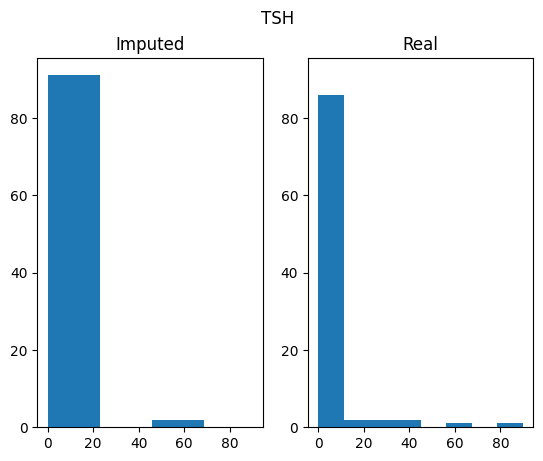

None

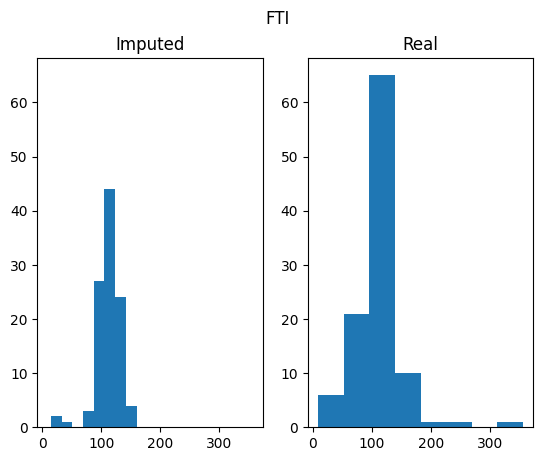

None

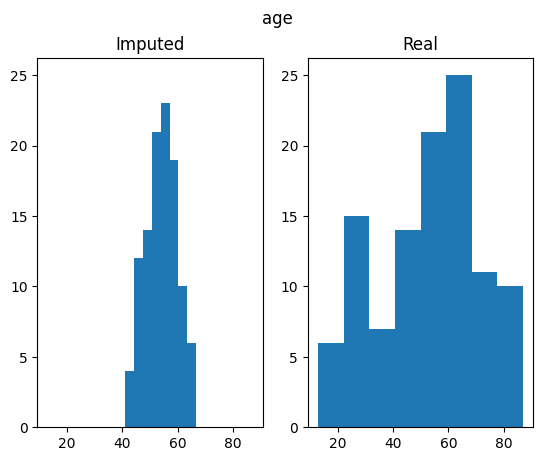

None

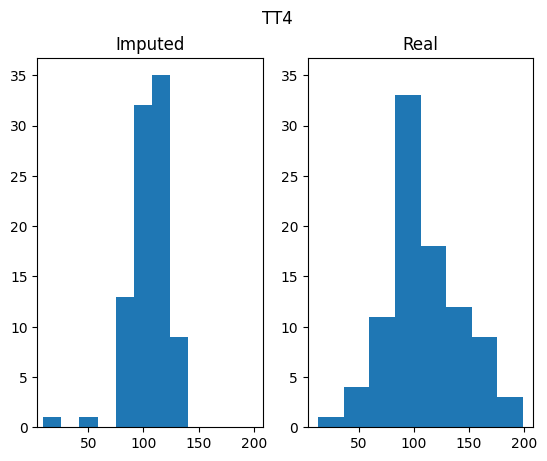

None

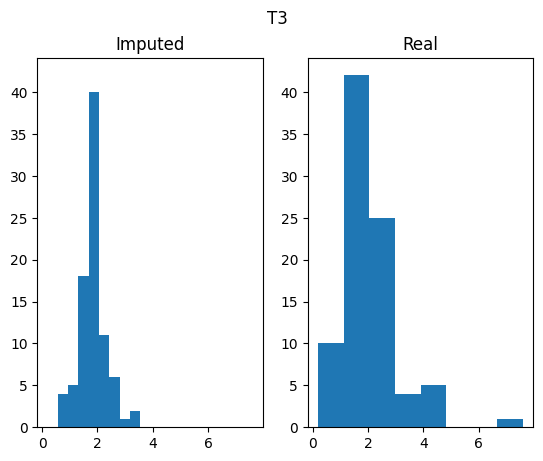

None

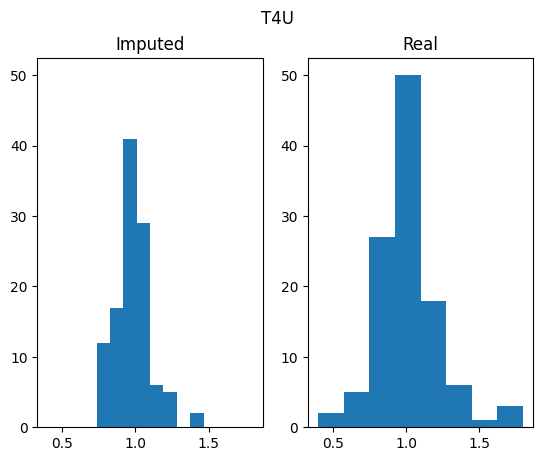

None

In [108]:
imputed_dict, real_dict = imputed_vals(sel_qual_cols, knn_imputed_df)
for col in sel_qual_cols:
    _, ax = plt.subplots(1, 2)
    ax[0].hist(x=imputed_dict[col], bins=sturges(len(imputed_dict[col])))
    ax[1].hist(x=real_dict[col], bins=sturges(len(real_dict[col])))
    imputed_ylim = ax[0].get_ylim()
    real_ylim = ax[1].get_ylim()
    true_ylim_max = max([imputed_ylim[1], real_ylim[1]])
    real_xlim = ax[1].get_xlim()
    min_val = real_xlim[0]
    max_val = real_xlim[1]
    ax[0].set_xlim((min_val, max_val))
    ax[1].set_xlim((min_val, max_val))
    ax[0].set_ylim((0, true_ylim_max))
    ax[1].set_ylim((0, true_ylim_max))
    ax[0].set_title("Imputed")
    ax[1].set_title("Real")
    plt.suptitle(col)
    display(plt.show())

## WKNN

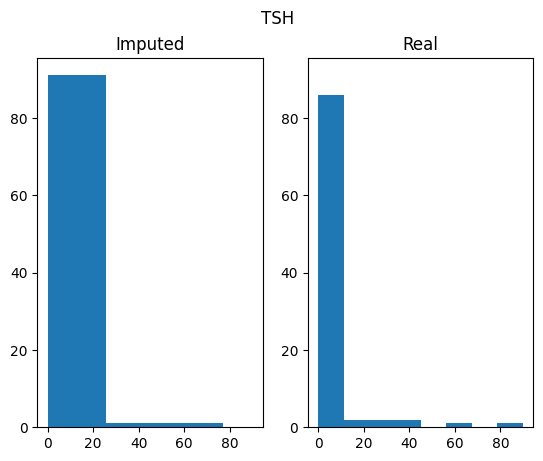

None

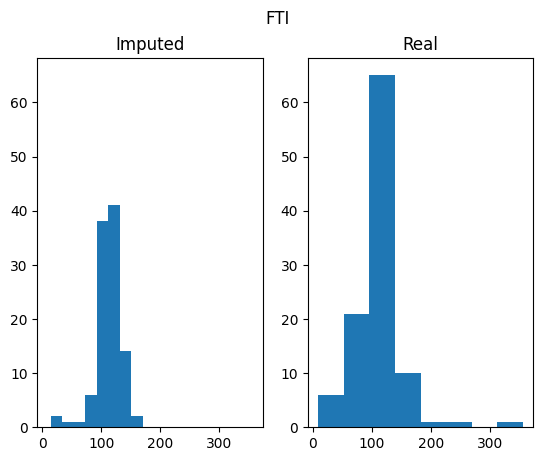

None

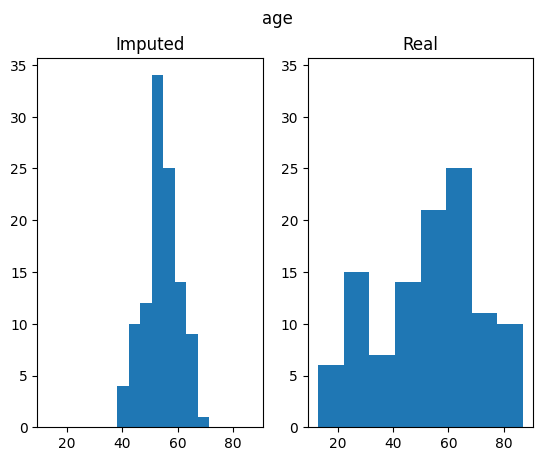

None

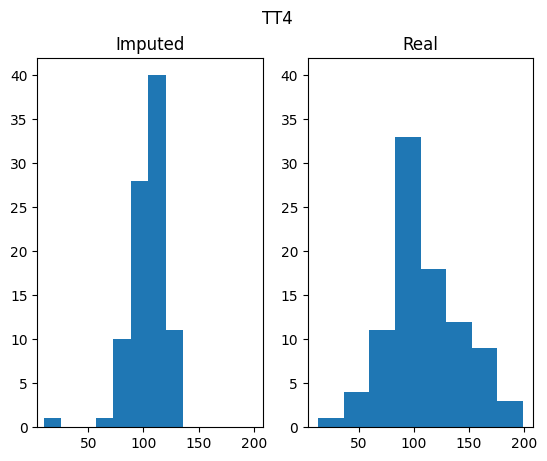

None

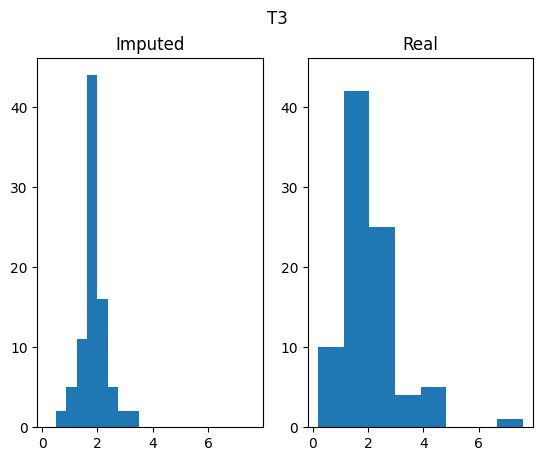

None

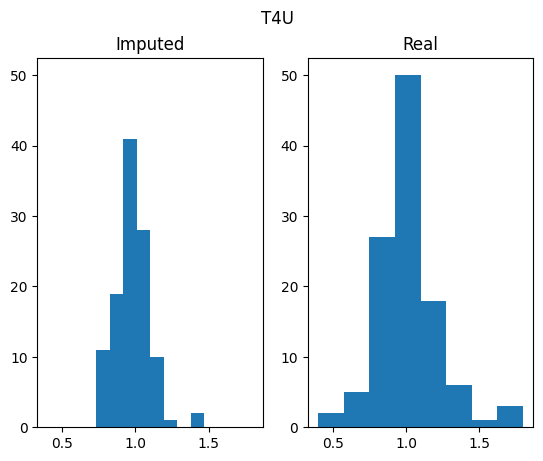

None

In [109]:
imputed_dict, real_dict = imputed_vals(sel_qual_cols, wknn_imputed_df)
for col in sel_qual_cols:
    _, ax = plt.subplots(1, 2)
    ax[0].hist(x=imputed_dict[col], bins=sturges(len(imputed_dict[col])))
    ax[1].hist(x=real_dict[col], bins=sturges(len(real_dict[col])))
    imputed_ylim = ax[0].get_ylim()
    real_ylim = ax[1].get_ylim()
    true_ylim_max = max([imputed_ylim[1], real_ylim[1]])
    real_xlim = ax[1].get_xlim()
    min_val = real_xlim[0]
    max_val = real_xlim[1]
    ax[0].set_xlim((min_val, max_val))
    ax[1].set_xlim((min_val, max_val))
    ax[0].set_ylim((0, true_ylim_max))
    ax[1].set_ylim((0, true_ylim_max))
    ax[0].set_title("Imputed")
    ax[1].set_title("Real")
    plt.suptitle(col)
    display(plt.show())

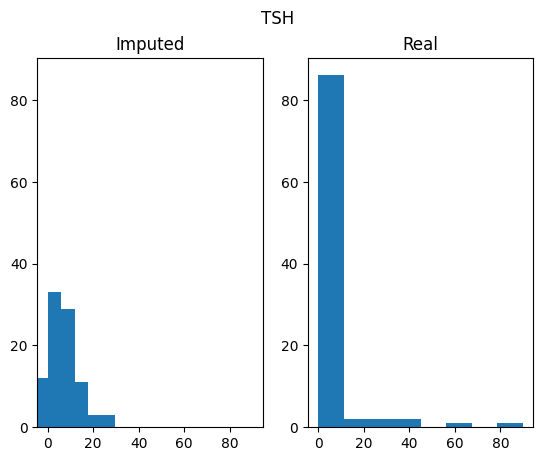

None

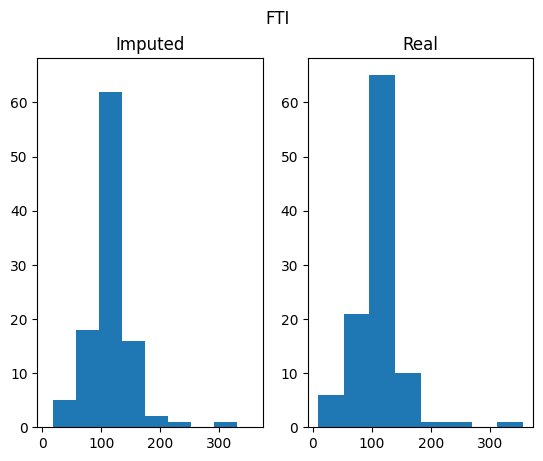

None

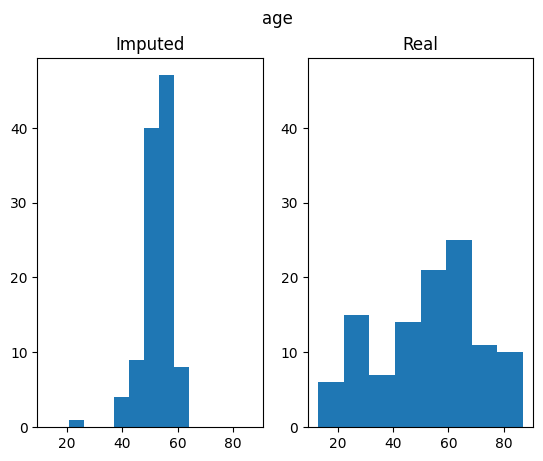

None

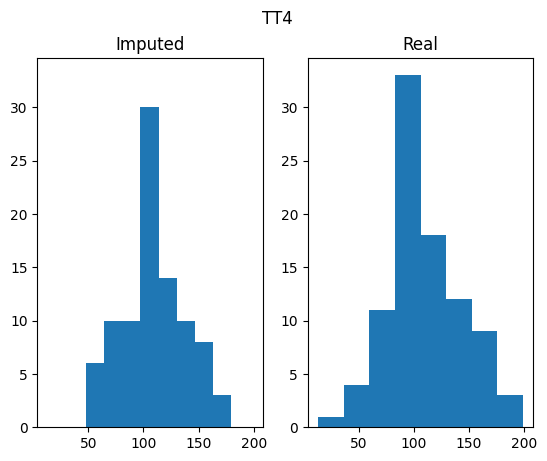

None

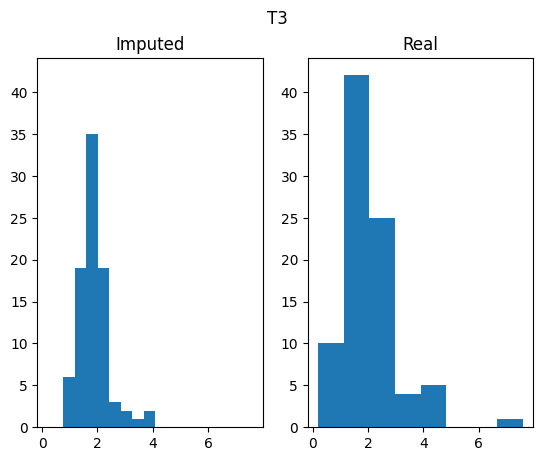

None

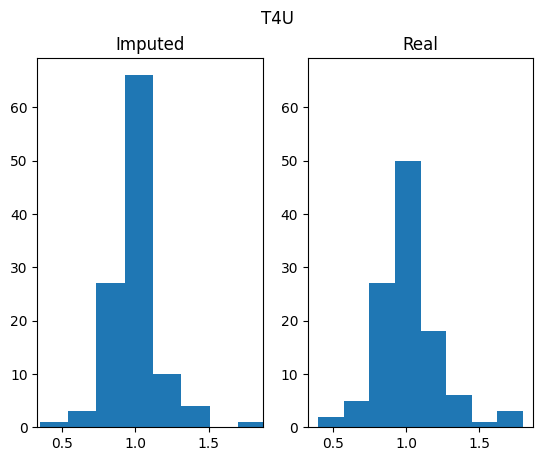

None

In [110]:
imputed_dict, real_dict = imputed_vals(sel_qual_cols, mice_imputed_df)
for col in sel_qual_cols:
    _, ax = plt.subplots(1, 2)
    ax[0].hist(x=imputed_dict[col], bins=sturges(len(imputed_dict[col])))
    ax[1].hist(x=real_dict[col], bins=sturges(len(real_dict[col])))
    imputed_ylim = ax[0].get_ylim()
    real_ylim = ax[1].get_ylim()
    true_ylim_max = max([imputed_ylim[1], real_ylim[1]])
    real_xlim = ax[1].get_xlim()
    min_val = real_xlim[0]
    max_val = real_xlim[1]
    ax[0].set_xlim((min_val, max_val))
    ax[1].set_xlim((min_val, max_val))
    ax[0].set_ylim((0, true_ylim_max))
    ax[1].set_ylim((0, true_ylim_max))
    ax[0].set_title("Imputed")
    ax[1].set_title("Real")
    plt.suptitle(col)
    display(plt.show())

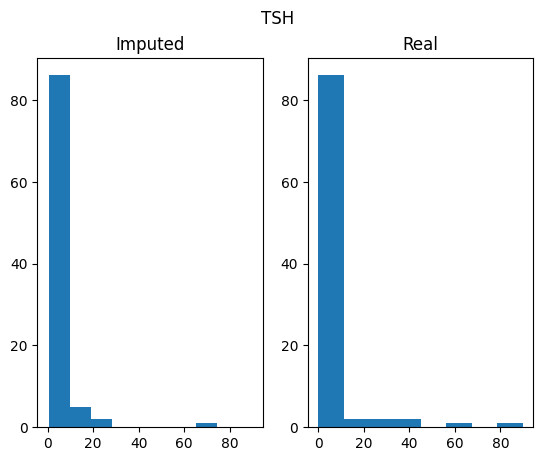

None

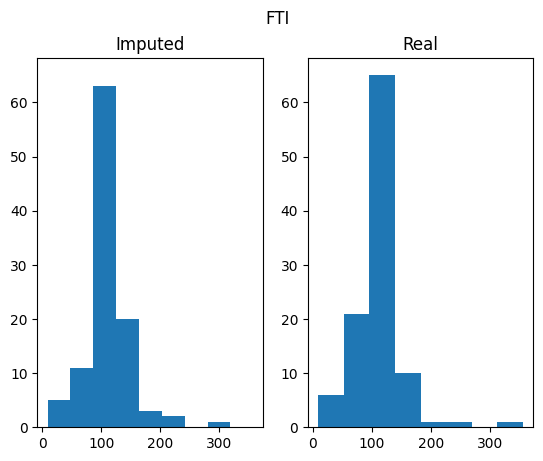

None

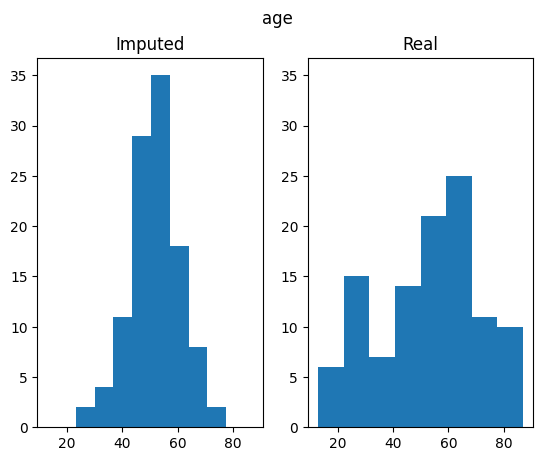

None

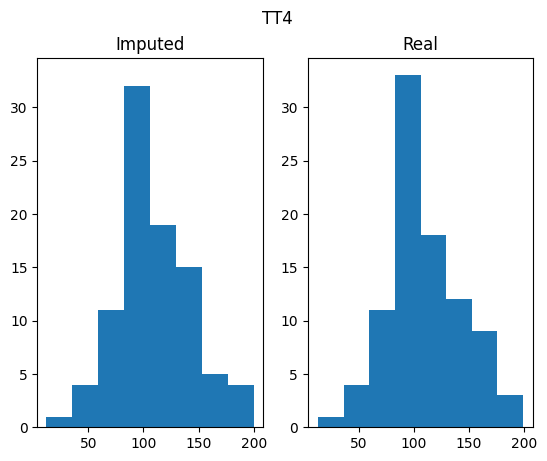

None

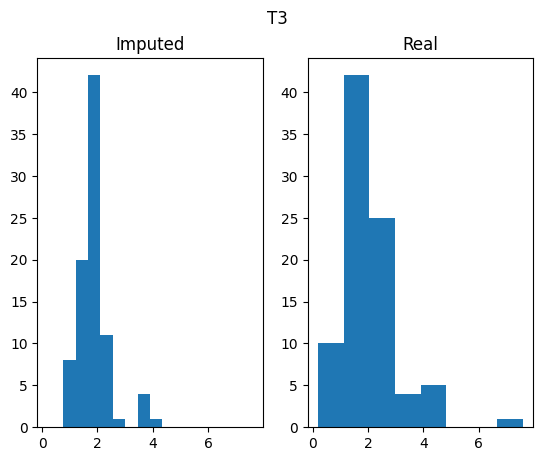

None

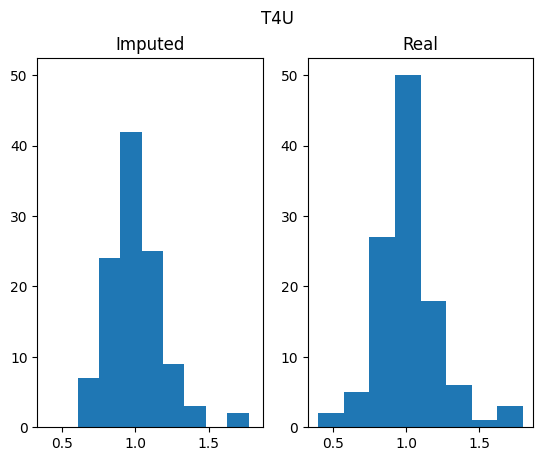

None

In [111]:
imputed_dict, real_dict = imputed_vals(sel_qual_cols, mice_rf_imputed_df)
for col in sel_qual_cols:
    _, ax = plt.subplots(1, 2)
    ax[0].hist(x=imputed_dict[col], bins=sturges(len(imputed_dict[col])))
    ax[1].hist(x=real_dict[col], bins=sturges(len(real_dict[col])))
    imputed_ylim = ax[0].get_ylim()
    real_ylim = ax[1].get_ylim()
    true_ylim_max = max([imputed_ylim[1], real_ylim[1]])
    real_xlim = ax[1].get_xlim()
    min_val = real_xlim[0]
    max_val = real_xlim[1]
    ax[0].set_xlim((min_val, max_val))
    ax[1].set_xlim((min_val, max_val))
    ax[0].set_ylim((0, true_ylim_max))
    ax[1].set_ylim((0, true_ylim_max))
    ax[0].set_title("Imputed")
    ax[1].set_title("Real")
    plt.suptitle(col)
    display(plt.show())

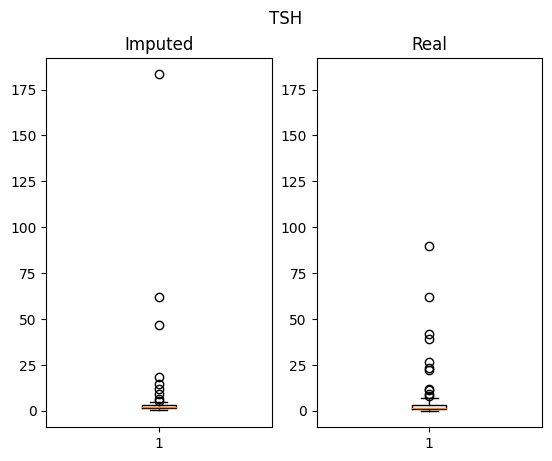

None

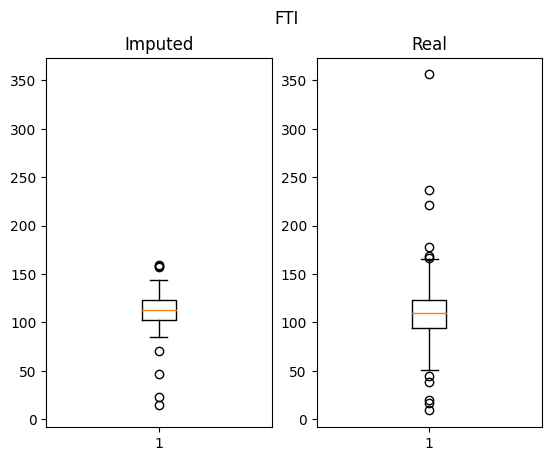

None

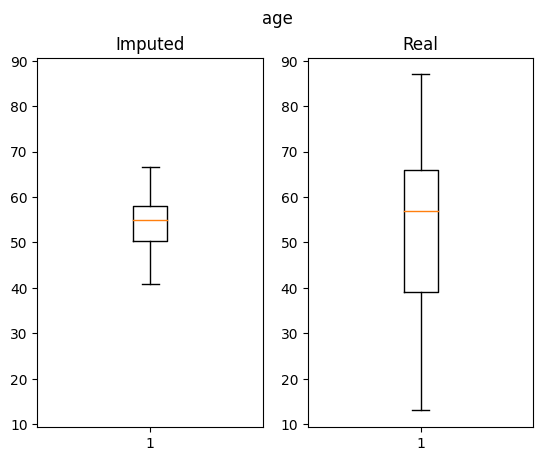

None

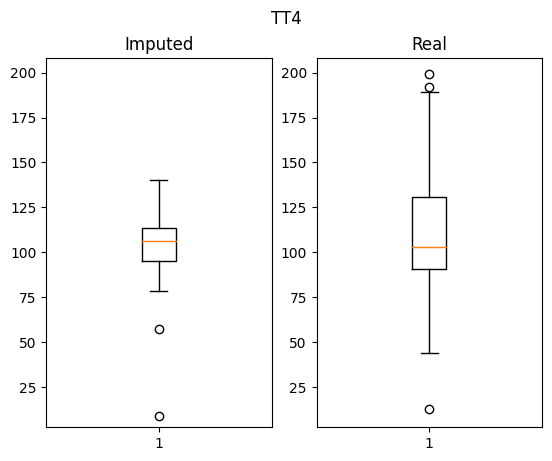

None

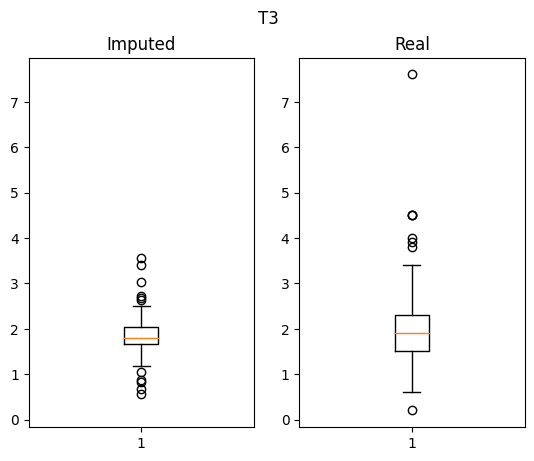

None

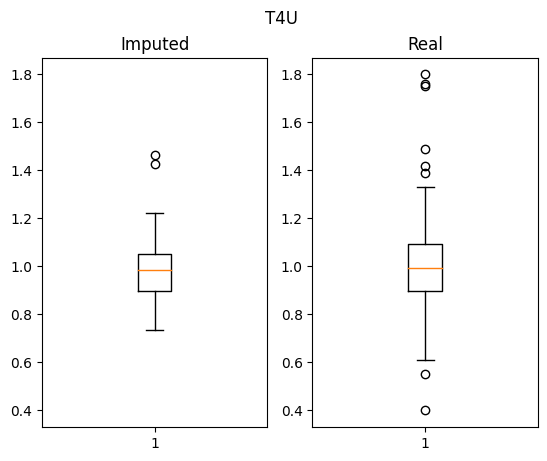

None

In [112]:
imputed_dict, real_dict = imputed_vals(sel_qual_cols, knn_imputed_df)
for col in sel_qual_cols:
    _, ax = plt.subplots(1, 2)
    ax[0].boxplot(x=imputed_dict[col])
    ax[1].boxplot(x=real_dict[col])
    imputed_ylim = ax[0].get_ylim()
    real_ylim = ax[1].get_ylim()
    ylim_min = min([imputed_ylim[0], real_ylim[0]])
    ylim_max = max([imputed_ylim[1], real_ylim[1]])
    ax[0].set_ylim((ylim_min, ylim_max))
    ax[1].set_ylim((ylim_min, ylim_max))
    ax[0].set_title("Imputed")
    ax[1].set_title("Real")
    plt.suptitle(col)
    display(plt.show())

In [ ]:
imputed_dict, real_dict = imputed_vals(sel_qual_cols, wknn_imputed_df)
for col in sel_qual_cols:
    _, ax = plt.subplots(1, 2)
    ax[0].boxplot(x=imputed_dict[col])
    ax[1].boxplot(x=real_dict[col])
    imputed_ylim = ax[0].get_ylim()
    real_ylim = ax[1].get_ylim()
    ylim_min = min([imputed_ylim[0], real_ylim[0]])
    ylim_max = max([imputed_ylim[1], real_ylim[1]])
    ax[0].set_ylim((ylim_min, ylim_max))
    ax[1].set_ylim((ylim_min, ylim_max))
    ax[0].set_title("Imputed")
    ax[1].set_title("Real")
    plt.suptitle(col)
    display(plt.show())

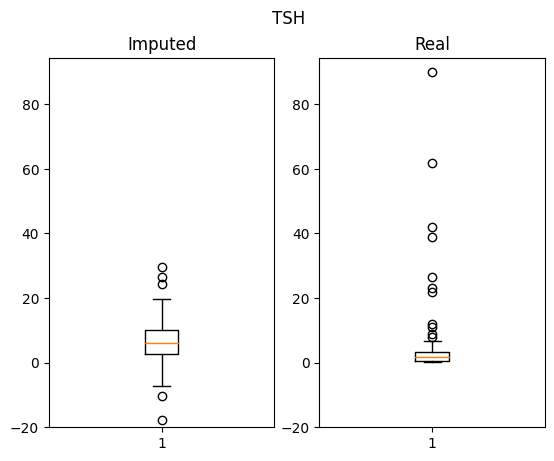

None

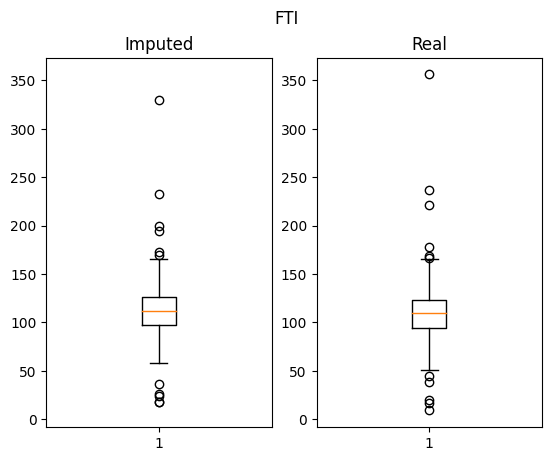

None

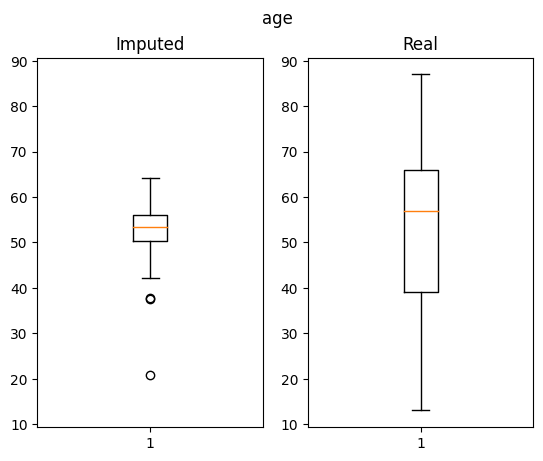

None

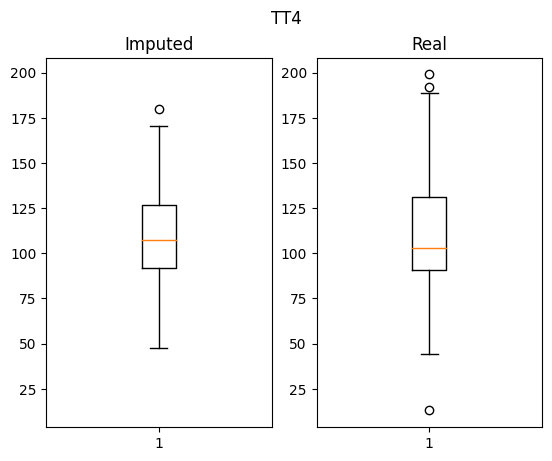

None

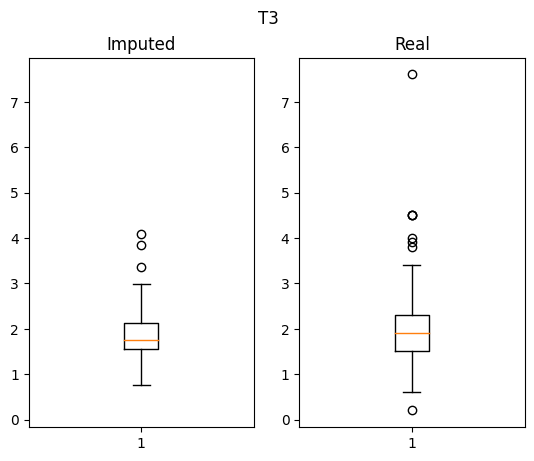

None

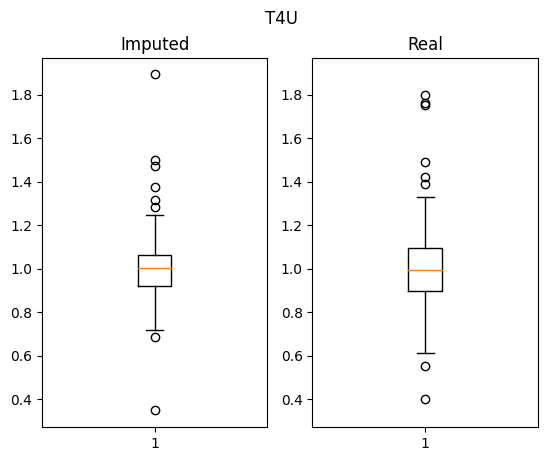

None

In [113]:
imputed_dict, real_dict = imputed_vals(sel_qual_cols, mice_imputed_df)
for col in sel_qual_cols:
    _, ax = plt.subplots(1, 2)
    ax[0].boxplot(x=imputed_dict[col])
    ax[1].boxplot(x=real_dict[col])
    imputed_ylim = ax[0].get_ylim()
    real_ylim = ax[1].get_ylim()
    ylim_min = min([imputed_ylim[0], real_ylim[0]])
    ylim_max = max([imputed_ylim[1], real_ylim[1]])
    ax[0].set_ylim((ylim_min, ylim_max))
    ax[1].set_ylim((ylim_min, ylim_max))
    ax[0].set_title("Imputed")
    ax[1].set_title("Real")
    plt.suptitle(col)
    display(plt.show())

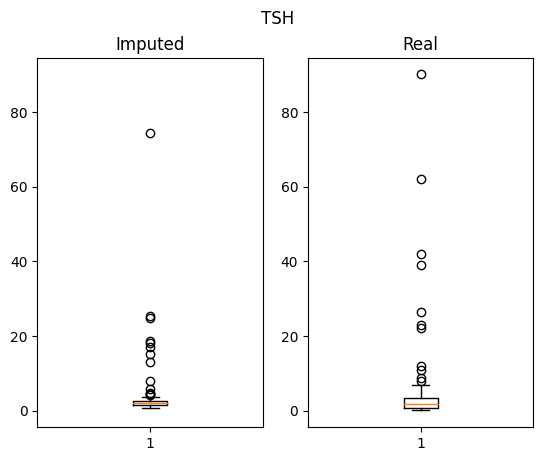

None

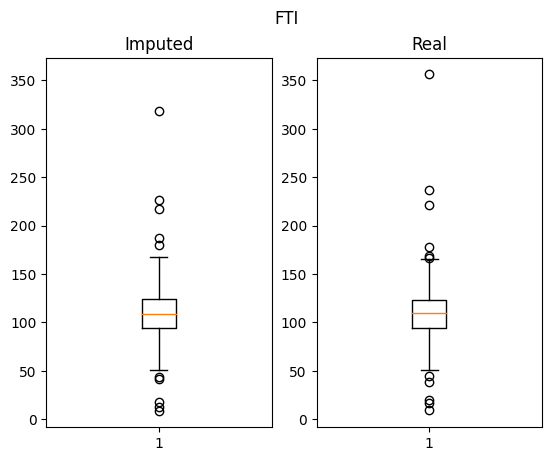

None

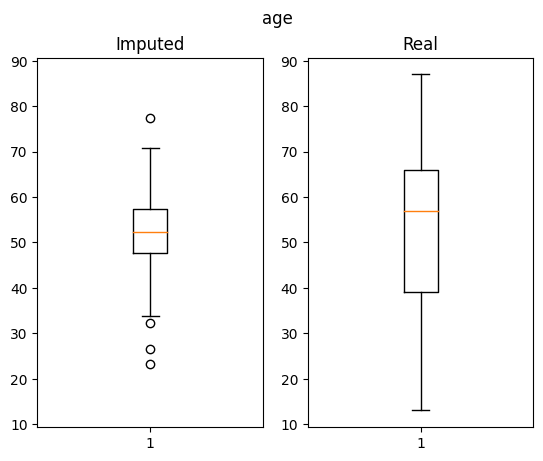

None

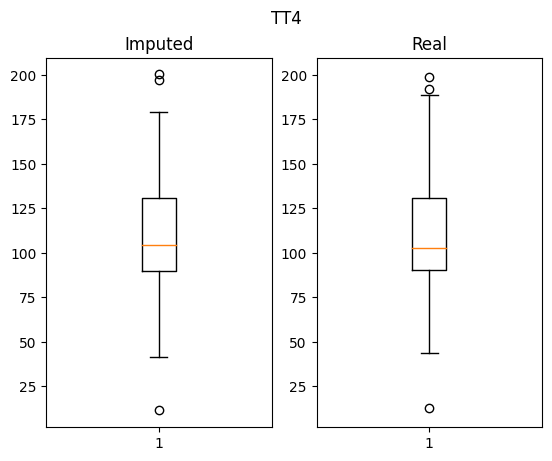

None

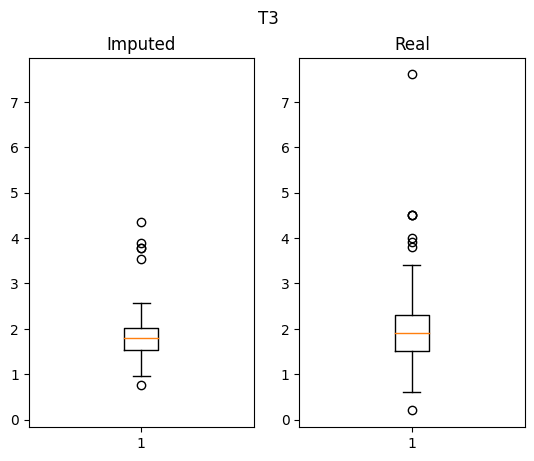

None

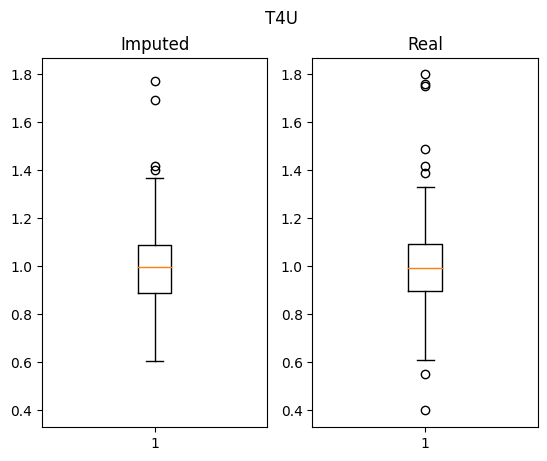

None

In [114]:
imputed_dict, real_dict = imputed_vals(sel_qual_cols, mice_rf_imputed_df)
for col in sel_qual_cols:
    _, ax = plt.subplots(1, 2)
    ax[0].boxplot(x=imputed_dict[col])
    ax[1].boxplot(x=real_dict[col])
    imputed_ylim = ax[0].get_ylim()
    real_ylim = ax[1].get_ylim()
    ylim_min = min([imputed_ylim[0], real_ylim[0]])
    ylim_max = max([imputed_ylim[1], real_ylim[1]])
    ax[0].set_ylim((ylim_min, ylim_max))
    ax[1].set_ylim((ylim_min, ylim_max))
    ax[0].set_title("Imputed")
    ax[1].set_title("Real")
    plt.suptitle(col)
    display(plt.show())

In [115]:
imputed_sqr_err(sel_qual_cols, knn_imputed_df)

{'TSH': 181.57935527155848,
 'FTI': 962.2901397712188,
 'age': 374.0963302752295,
 'TT4': 624.6786032967032,
 'T3': 0.8055616781609194,
 'T4U': 0.016592776785714282}

In [131]:
imputed_sqr_err(sel_qual_cols, wknn_imputed_df)

{'TSH': 229.14007159978954,
 'FTI': 927.7405131440105,
 'age': 385.09437107433183,
 'TT4': 638.1741921887051,
 'T3': 0.8441456530897609,
 'T4U': 0.01788956948848045}

In [116]:
imputed_sqr_err(sel_qual_cols, mice_imputed_df)

{'TSH': 133.0033484327084,
 'FTI': 47.39268623554878,
 'age': 300.1211420254812,
 'TT4': 67.9018720695172,
 'T3': 0.7052811985467761,
 'T4U': 0.008659140526038733}

In [117]:
display(knn_imputed_df[real_cols].mean())
display(knn_imputed_df[imputed_cols].mean())

TSH (real)      7.229992
FTI (real)    108.398161
age (real)     53.391304
TT4 (real)    104.268729
T3 (real)       1.945368
T4U (real)      0.978729
dtype: float64

TSH (imputed)      7.304526
FTI (imputed)    108.363144
age (imputed)     53.619732
TT4 (imputed)    103.463428
T3 (imputed)       1.920676
T4U (imputed)      0.974166
dtype: float64

In [118]:
display(knn_imputed_df[real_cols].std())
display(knn_imputed_df[imputed_cols].std())

TSH (real)    35.280395
FTI (real)    36.049734
age (real)    18.703471
TT4 (real)    36.788046
T3 (real)      0.839922
T4U (real)     0.201820
dtype: float64

TSH (imputed)    35.809736
FTI (imputed)    32.869364
age (imputed)    17.136980
TT4 (imputed)    34.920187
T3 (imputed)      0.766294
T4U (imputed)     0.186156
dtype: float64

In [132]:
display(wknn_imputed_df[real_cols].mean())
display(wknn_imputed_df[imputed_cols].mean())

TSH (real)      7.229992
FTI (real)    108.398161
age (real)     53.391304
TT4 (real)    104.268729
T3 (real)       1.945368
T4U (real)      0.978729
dtype: float64

TSH (imputed)      7.353338
FTI (imputed)    108.429923
age (imputed)     53.646049
TT4 (imputed)    103.346128
T3 (imputed)       1.920206
T4U (imputed)      0.973873
dtype: float64

In [133]:
display(wknn_imputed_df[real_cols].std())
display(wknn_imputed_df[imputed_cols].std())

TSH (real)    35.280395
FTI (real)    36.049734
age (real)    18.703471
TT4 (real)    36.788046
T3 (real)      0.839922
T4U (real)     0.201820
dtype: float64

TSH (imputed)    36.011634
FTI (imputed)    32.977354
age (imputed)    17.184261
TT4 (imputed)    34.919752
T3 (imputed)      0.765747
T4U (imputed)     0.185840
dtype: float64

In [119]:
neighbour_range = range(1, 17)

In [120]:
knn_mse_df_dict = {
    "neighbours" : [],
    "col" : [],
    "val" : []
}

for curr_neighbours in neighbour_range:
    knn_imputer = KNNImputer(n_neighbors=curr_neighbours)
    knn_imputed_mat = knn_imputer.fit_transform(curr_df)

    knn_imputed_df = pd.DataFrame(knn_imputed_mat, columns=real_df.columns, index=real_df.index)
    knn_imputed_df = knn_imputed_df.loc[missing_vals_idxs]

    for col in remove_vals_df.columns:
        knn_imputed_df["{} (real)".format(col)] = remove_vals_df[col]
        knn_imputed_df["{} (imputed)".format(col)] = knn_imputed_df[col]
        knn_imputed_df.drop([col], axis=1, inplace=True)

    knn_imputed_df["imputed"] = picked_cols

    sqr_err_dict = imputed_sqr_err(sel_qual_cols, knn_imputed_df)
    
    for col in sel_qual_cols:
        knn_mse_df_dict["col"].append(col)
        knn_mse_df_dict["val"].append(sqr_err_dict[col])
        knn_mse_df_dict["neighbours"].append(curr_neighbours)
        
knn_mse_df = pd.DataFrame(knn_mse_df_dict)

In [135]:
wknn_mse_df_dict = {
    "neighbours" : [],
    "col" : [],
    "val" : []
}

for curr_neighbours in neighbour_range:
    wknn_imputer = KNNImputer(n_neighbors=curr_neighbours, weights="distance")
    wknn_imputed_mat = wknn_imputer.fit_transform(curr_df)

    wknn_imputed_df = pd.DataFrame(wknn_imputed_mat, columns=real_df.columns, index=real_df.index)
    wknn_imputed_df = wknn_imputed_df.loc[missing_vals_idxs]

    for col in remove_vals_df.columns:
        wknn_imputed_df["{} (real)".format(col)] = remove_vals_df[col]
        wknn_imputed_df["{} (imputed)".format(col)] = wknn_imputed_df[col]
        wknn_imputed_df.drop([col], axis=1, inplace=True)

    wknn_imputed_df["imputed"] = picked_cols

    sqr_err_dict = imputed_sqr_err(sel_qual_cols, wknn_imputed_df)
    
    for col in sel_qual_cols:
        wknn_mse_df_dict["col"].append(col)
        wknn_mse_df_dict["val"].append(sqr_err_dict[col])
        wknn_mse_df_dict["neighbours"].append(curr_neighbours)
        
wknn_mse_df = pd.DataFrame(wknn_mse_df_dict)

In [121]:
import seaborn as sns

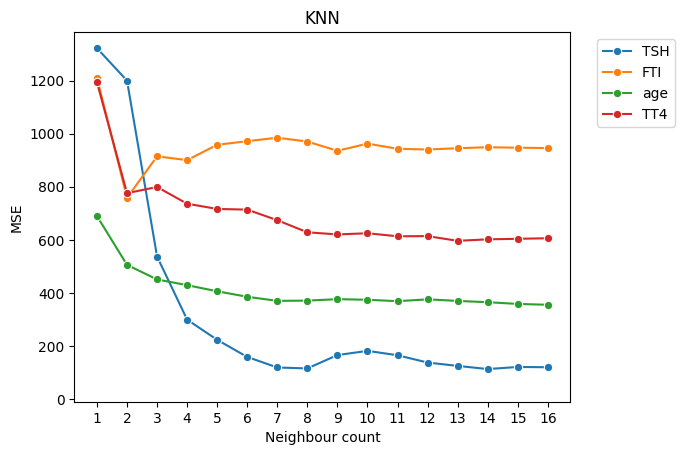

In [142]:
sns.lineplot(data=knn_mse_df[(knn_mse_df["col"] != "T3") & (knn_mse_df["col"] != "T4U")], x="neighbours", y="val", hue="col", marker="o")
plt.ylim(-10, plt.ylim()[1])
plt.ylabel("MSE")
plt.xlabel("Neighbour count")
plt.xticks(neighbour_range)
plt.title("KNN")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

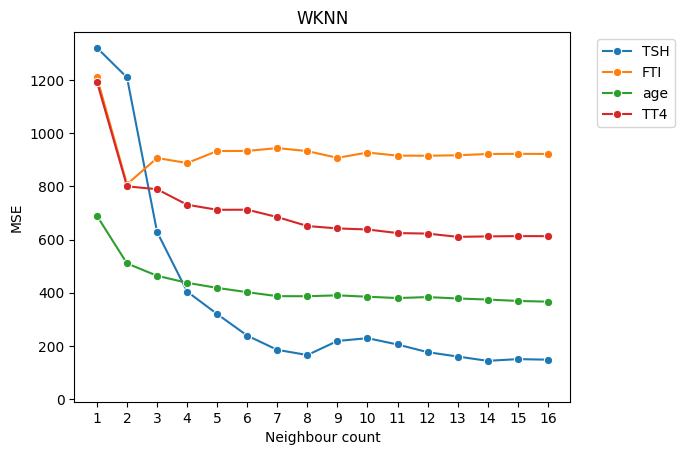

In [143]:
sns.lineplot(data=wknn_mse_df[(wknn_mse_df["col"] != "T3") & (wknn_mse_df["col"] != "T4U")], x="neighbours", y="val", hue="col", marker="o")
plt.ylim(-10, plt.ylim()[1])
plt.ylabel("MSE")
plt.xlabel("Neighbour count")
plt.title("WKNN")
plt.xticks(neighbour_range)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

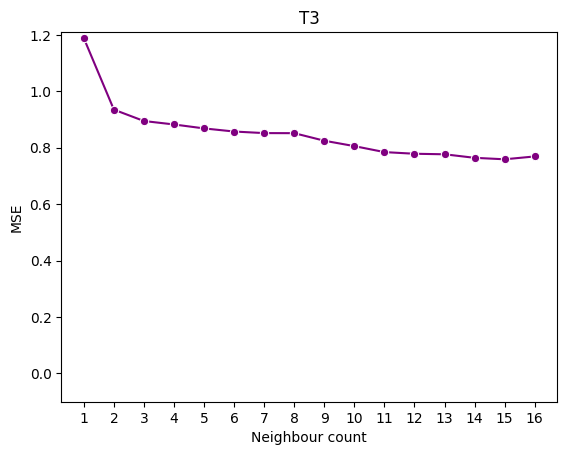

In [123]:
sns.lineplot(data=knn_mse_df[(knn_mse_df["col"] == "T3")], x="neighbours", y="val", marker="o", color="purple")
plt.ylim(-0.1, plt.ylim()[1])
plt.ylabel("MSE")
plt.xlabel("Neighbour count")
plt.xticks(neighbour_range)
plt.title("KNN - T3")
plt.show()

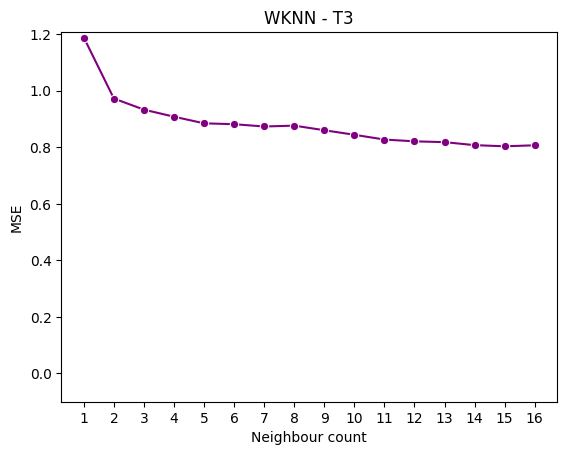

In [144]:
sns.lineplot(data=wknn_mse_df[(wknn_mse_df["col"] == "T3")], x="neighbours", y="val", marker="o", color="purple")
plt.ylim(-0.1, plt.ylim()[1])
plt.ylabel("MSE")
plt.xlabel("Neighbour count")
plt.xticks(neighbour_range)
plt.title("WKNN - T3")
plt.show()

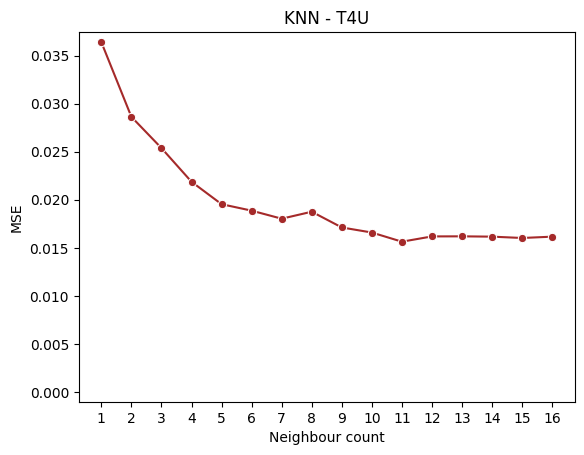

In [138]:
sns.lineplot(data=knn_mse_df[(knn_mse_df["col"] == "T4U")], x="neighbours", y="val", marker="o", color="brown")
plt.ylim(-0.001, plt.ylim()[1])
plt.ylabel("MSE")
plt.xlabel("Neighbour count")
plt.xticks(neighbour_range)
plt.title("KNN - T4U")
plt.show()

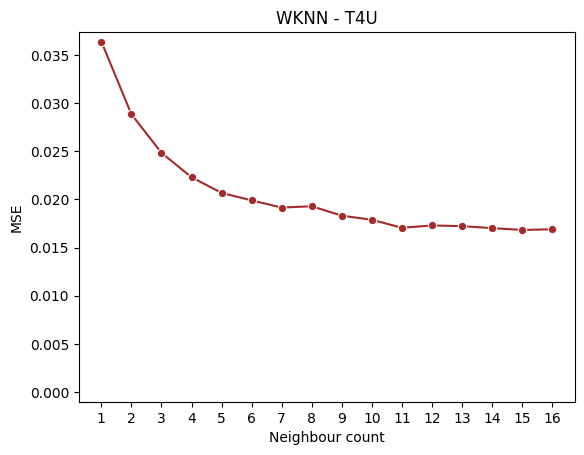

In [140]:
sns.lineplot(data=wknn_mse_df[(wknn_mse_df["col"] == "T4U")], x="neighbours", y="val", marker="o", color="brown")
plt.ylim(-0.001, plt.ylim()[1])
plt.ylabel("MSE")
plt.xlabel("Neighbour count")
plt.xticks(neighbour_range)
plt.title("WKNN - T4U")
plt.show()

In [125]:
iter_range = []
for i in range(0, 20):
    iter_range.append(i)

In [126]:
mice_mse_df_dict = {
    "max_iters" : [],
    "col" : [],
    "val" : []
}

for i in iter_range:

    mice_imputer = IterativeImputer(random_state=random_state, max_iter=i)
    mice_imputed_mat = mice_imputer.fit_transform(curr_df)

    mice_imputed_df = pd.DataFrame(mice_imputed_mat, columns=real_df.columns, index=real_df.index)
    mice_imputed_df = mice_imputed_df.loc[missing_vals_idxs]

    for col in remove_vals_df.columns:
        mice_imputed_df["{} (real)".format(col)] = remove_vals_df[col]
        mice_imputed_df["{} (imputed)".format(col)] = mice_imputed_df[col]
        mice_imputed_df.drop([col], axis=1, inplace=True)

    mice_imputed_df["imputed"] = picked_cols

    sqr_err_dict = imputed_sqr_err(sel_qual_cols, mice_imputed_df)
        
    for col in sel_qual_cols:
        mice_mse_df_dict["col"].append(col)
        mice_mse_df_dict["val"].append(sqr_err_dict[col])
        mice_mse_df_dict["max_iters"].append(i)

mice_mse_df = pd.DataFrame(mice_mse_df_dict)    

C:\Users\milal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\milal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


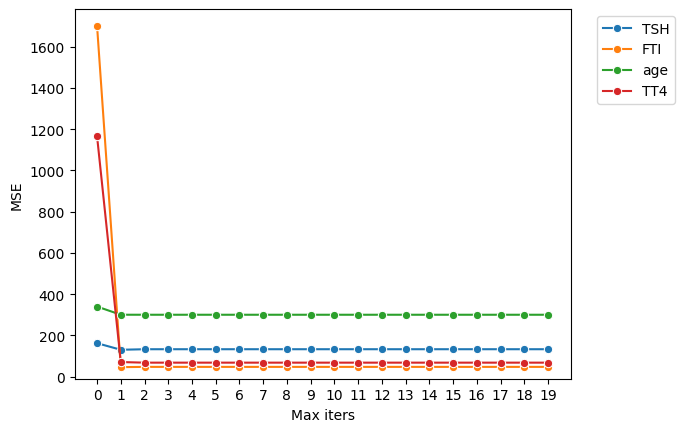

In [127]:
sns.lineplot(data=mice_mse_df[(mice_mse_df["col"] != "T3") & (mice_mse_df["col"] != "T4U")], x="max_iters", y="val", hue="col", marker="o")
plt.ylim(-10, plt.ylim()[1])
plt.ylabel("MSE")
plt.xlabel("Max iters")
plt.xticks(iter_range)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.xscale("log")
plt.show()

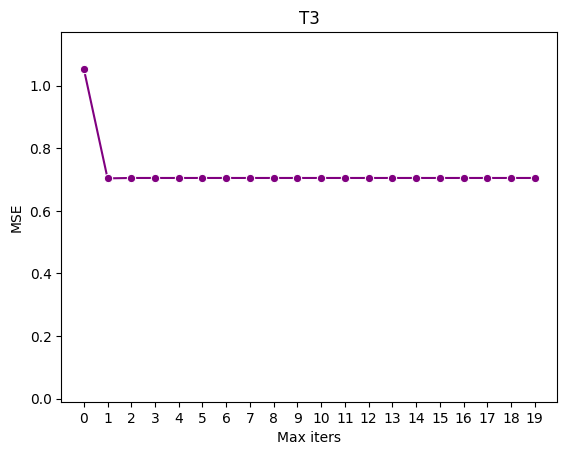

In [128]:
sns.lineplot(data=mice_mse_df[(mice_mse_df["col"] == "T3")], x="max_iters", y="val", marker="o", color="purple")
plt.ylim(-0.01, plt.ylim()[1] + 0.1)
plt.ylabel("MSE")
plt.xlabel("Max iters")
plt.xticks(iter_range)
#plt.xscale("log")
plt.title("T3")
plt.show()

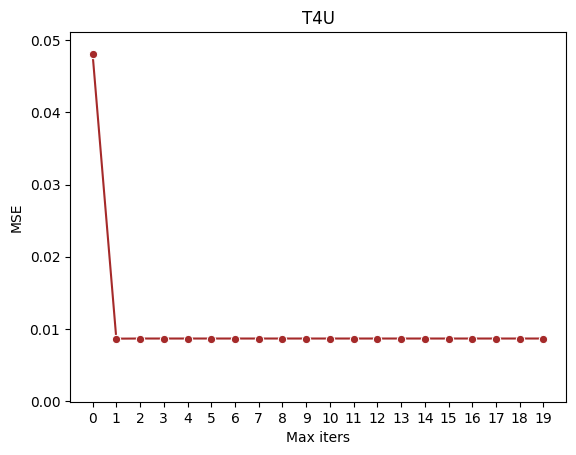

In [129]:
sns.lineplot(data=mice_mse_df[(mice_mse_df["col"] == "T4U")], x="max_iters", y="val", marker="o", color="brown")
plt.ylim(-0.0001, plt.ylim()[1] + 0.001)
plt.ylabel("MSE")
plt.xlabel("Max iters")
plt.xticks(iter_range)
#plt.xscale("log")
plt.title("T4U")
plt.show()

In [130]:
mice_rf_mse_df_dict = {
    "max_iters" : [],
    "col" : [],
    "val" : []
}

for i in iter_range:

    mice_rf_imputer = IterativeImputer(random_state=random_state, max_iter=i, estimator=RandomForestRegressor(
        n_estimators=4,
        max_depth=10,
        bootstrap=True,
        max_samples=0.5,
        n_jobs=2,
        random_state=random_state,
    ))
    mice_rf_imputed_mat = mice_rf_imputer.fit_transform(curr_df)

    mice_rf_imputed_df = pd.DataFrame(mice_rf_imputed_mat, columns=real_df.columns, index=real_df.index)
    mice_rf_imputed_df = mice_rf_imputed_df.loc[missing_vals_idxs]

    for col in remove_vals_df.columns:
        mice_rf_imputed_df["{} (real)".format(col)] = remove_vals_df[col]
        mice_rf_imputed_df["{} (imputed)".format(col)] = mice_rf_imputed_df[col]
        mice_rf_imputed_df.drop([col], axis=1, inplace=True)

    mice_rf_imputed_df["imputed"] = picked_cols

    sqr_err_dict = imputed_sqr_err(sel_qual_cols, mice_rf_imputed_df)
        
    for col in sel_qual_cols:
        mice_rf_mse_df_dict["col"].append(col)
        mice_rf_mse_df_dict["val"].append(sqr_err_dict[col])
        mice_rf_mse_df_dict["max_iters"].append(i)

mice_rf_mse_df = pd.DataFrame(mice_rf_mse_df_dict)    

C:\Users\milal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\milal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\milal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\milal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImpu

KeyboardInterrupt: 

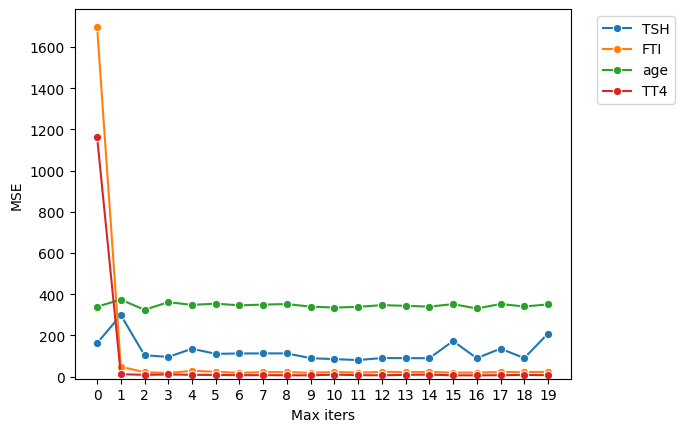

In [ ]:
sns.lineplot(data=mice_rf_mse_df[(mice_rf_mse_df["col"] != "T3") & (mice_rf_mse_df["col"] != "T4U")], x="max_iters", y="val", hue="col", marker="o")
plt.ylim(-10, plt.ylim()[1])
plt.ylabel("MSE")
plt.xlabel("Max iters")
plt.xticks(iter_range)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.xscale("log")
plt.show()

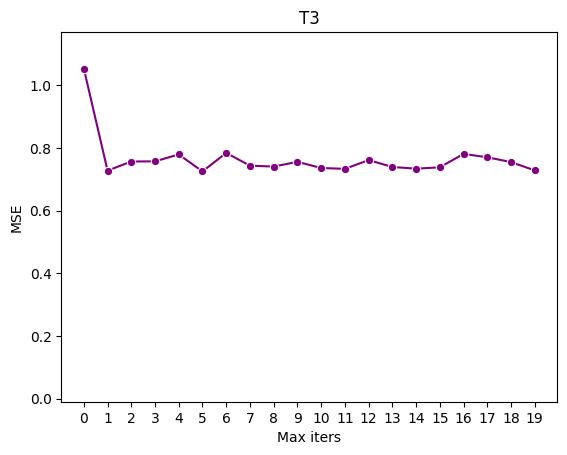

In [ ]:
sns.lineplot(data=mice_rf_mse_df[(mice_rf_mse_df["col"] == "T3")], x="max_iters", y="val", marker="o", color="purple")
plt.ylim(-0.01, plt.ylim()[1] + 0.1)
plt.ylabel("MSE")
plt.xlabel("Max iters")
plt.xticks(iter_range)
#plt.xscale("log")
plt.title("T3")
plt.show()

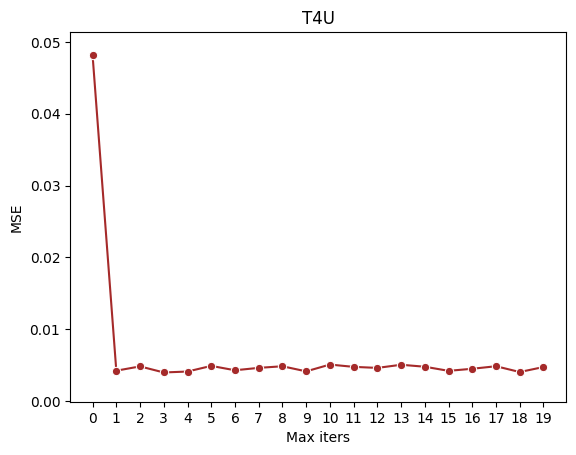

In [ ]:
sns.lineplot(data=mice_rf_mse_df[(mice_rf_mse_df["col"] == "T4U")], x="max_iters", y="val", marker="o", color="brown")
plt.ylim(-0.0001, plt.ylim()[1] + 0.001)
plt.ylabel("MSE")
plt.xlabel("Max iters")
plt.xticks(iter_range)
#plt.xscale("log")
plt.title("T4U")
plt.show()

In [ ]:
depths = [1,2,3,4,5,6,7,8,9,10,15,20,30,50,100]

In [ ]:
mice_rf_depth_mse_df_dict = {
    "depth" : [],
    "col" : [],
    "val" : []
}

for depth in depths:

    mice_rf_depth_imputer = IterativeImputer(random_state=random_state, max_iter=100, estimator=RandomForestRegressor(
        n_estimators=depth,
        max_depth=10,
        bootstrap=True,
        max_samples=0.5,
        n_jobs=2,
        random_state=random_state,
    ))
    mice_rf_depth_imputed_mat = mice_rf_depth_imputer.fit_transform(curr_df)

    mice_rf_depth_imputed_df = pd.DataFrame(mice_rf_depth_imputed_mat, columns=real_df.columns, index=real_df.index)
    mice_rf_depth_imputed_df = mice_rf_depth_imputed_df.loc[missing_vals_idxs]

    for col in remove_vals_df.columns:
        mice_rf_depth_imputed_df["{} (real)".format(col)] = remove_vals_df[col]
        mice_rf_depth_imputed_df["{} (imputed)".format(col)] = mice_rf_depth_imputed_df[col]
        mice_rf_depth_imputed_df.drop([col], axis=1, inplace=True)

    mice_rf_depth_imputed_df["imputed"] = picked_cols

    sqr_err_dict = imputed_sqr_err(sel_qual_cols, mice_rf_depth_imputed_df)
        
    for col in sel_qual_cols:
        mice_rf_depth_mse_df_dict["col"].append(col)
        mice_rf_depth_mse_df_dict["val"].append(sqr_err_dict[col])
        mice_rf_depth_mse_df_dict["depth"].append(depth)

mice_rf_depth_mse_df = pd.DataFrame(mice_rf_depth_mse_df_dict)    

C:\Users\milal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\milal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\milal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\milal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\impute\_iterative.py:800: ConvergenceWarning: [IterativeImpu

KeyboardInterrupt: 

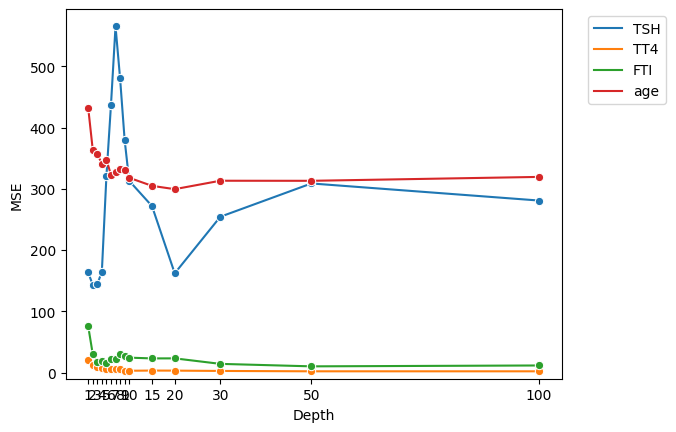

In [ ]:
sns.lineplot(data=mice_rf_depth_mse_df[(mice_rf_depth_mse_df["col"] != "T3") & (mice_rf_depth_mse_df["col"] != "T4U")], x="depth", y="val", hue="col", marker="o")
plt.ylim(-10, plt.ylim()[1])
plt.ylabel("MSE")
plt.xlabel("Depth")
plt.xticks(depths)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.xscale("log")
plt.show()

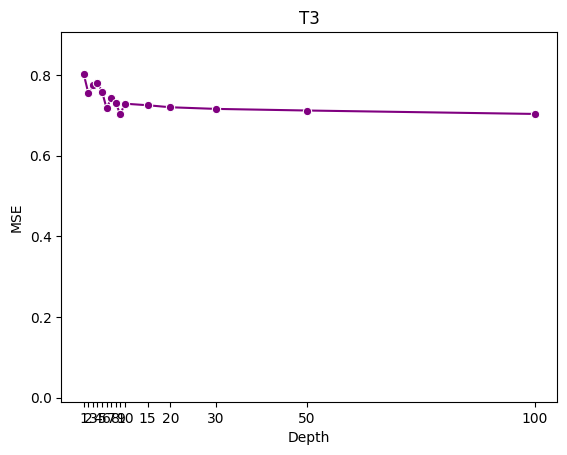

In [ ]:
sns.lineplot(data=mice_rf_depth_mse_df[(mice_rf_depth_mse_df["col"] == "T3")], x="depth", y="val", marker="o", color="purple")
plt.ylim(-0.01, plt.ylim()[1] + 0.1)
plt.ylabel("MSE")
plt.xlabel("Depth")
plt.xticks(depths)
#plt.xscale("log")
plt.title("T3")
plt.show()

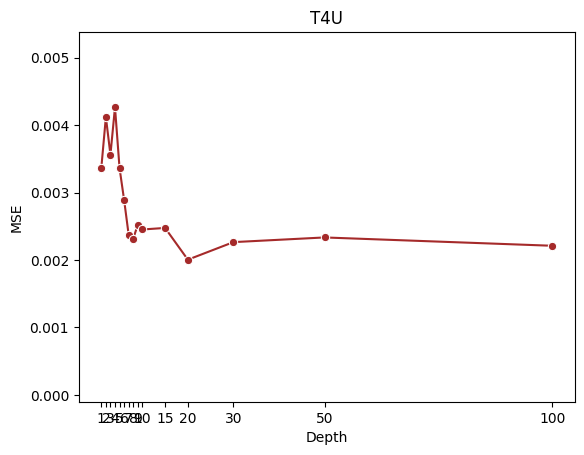

In [ ]:
sns.lineplot(data=mice_rf_depth_mse_df[(mice_rf_depth_mse_df["col"] == "T4U")], x="depth", y="val", marker="o", color="brown")
plt.ylim(-0.0001, plt.ylim()[1] + 0.001)
plt.ylabel("MSE")
plt.xlabel("Depth")
plt.xticks(depths)
#plt.xscale("log")
plt.title("T4U")
plt.show()